# Sverdrup analysis
## Tech preamble

In [1]:
%matplotlib inline
from pathlib import Path
import os
import gsw
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import cmocean as co     # for details on this colormap module see https://matplotlib.org/cmocean/
import numpy as np
import xarray as xr
import xscale.signal.fitting as xfit
import dask
from dask.distributed import Client
from datetime import timedelta
from datetime import datetime
import xskillscore as xs

/gxfs_work/geomar/smomw294/.conda/envs/py3_std/lib/python3.9/site-packages/xscale-0.1.dev0+35.ga804866-py3.9.egg/xscale/signal/generator.py:48: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def ar(coeffs, n, c=0.):


## Dask-jobqueue and clients

In [2]:
# import dask_jobqueue
# cluster = dask_jobqueue.SLURMCluster(
#     # Dask worker size
#     cores=4, memory='24GB',
#     processes=1, # Dask workers per job
#     # SLURM job script things
#     queue='cluster', walltime='00:45:00',
#     # Dask worker network and temporary storage
#     interface='ib0', local_directory='$TMPDIR',
#     log_directory='./slurm_logs'
# )

In [3]:
# client = Client(cluster)
client = Client(n_workers=1, threads_per_worker=8, memory_limit=24e9)

In [4]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 8,Total memory: 22.35 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46795,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 22.35 GiB
Comm: tcp://127.0.0.1:37053,Total threads: 8
Dashboard: http://127.0.0.1:34969/status,Memory: 22.35 GiB
Nanny: tcp://127.0.0.1:42181,


In [5]:
# cluster.adapt(
#     minimum=1, maximum=20,
# )

## Parameter preamble

In [6]:
calc_JRA = 1 #set 1 if sn_JRA should be recalculated
calc_CORE = 1 #set 1 if sn_CORE should be recalculated
global_data_path = Path("/gxfs_work1/geomar/smomw294/iAtlantic/Subprojects/Wind_forcing/data/INALT20_taux_tauy_10S10N")
global_data_path2 = Path("/gxfs_work1/geomar/smomw294/iAtlantic/Subprojects/Wind_forcing/data/INALT20_taux_tauy_10S10N")
JRA_exp_id = "INALT20.L46-KFS10?"
CORE_exp_id = "INALT20.L46-KFS044" # INALT COREv2

temp_res = "_5d_" # 5d:5-daily; 1m:monthly; 1y:yearly; 1d:daily(stored currently on TAPE) 
nest_prefix = "1_" # "1_" for high resolution; leave empty for base model

# chunk sizes
chu_x = 100 # None means take the full dataset
chu_y = 100
chu_z = 1
chu_t = None

# limits wanted
JRA_tlim = [1996,2018]
CORE_tlim = [1996,2009]
lat_lim,lon_lim = [-1.12,5.25],[-23.05,-15]
lat_lim1,lon_lim2 = [-6,8],[40,35,30,25,20]

## load YCM
EUC_data_path = Path("../data/INALT20_EUC_calc_transport/")
NEUC_data_path = Path("../data/INALT20_NEUC_calc_transport/")
SEUC_data_path = Path("../data/INALT20_SEUC_calc_transport/")
NECC_data_path = Path("../data/INALT20_NECC_calc_transport/")
nSECu_data_path = Path("../data/INALT20_nSECu_calc_transport/")

In [7]:
# Find data files
aux_files = list(sorted(
        (global_data_path).glob(f"{nest_prefix}[m,n]*.nc")
    ))

print(f"Found {len(aux_files)} mesh/mask files")

Found 1 mesh/mask files


In [8]:
script_name = "INALT20_wind_forcing_Sverdrup_ts"
out_dir_data = f"../data/{script_name}/"
Path(out_dir_data).mkdir(parents=True, exist_ok=True)

# out_fn_curl = f"INALT20_wind_curl_AH{temp_res}clim_{JRA_tlim[0]}_{JRA_tlim[1]}.nc"
# out_fn_taux = f"INALT20_wind_taux_AH{temp_res}clim_{JRA_tlim[0]}_{JRA_tlim[1]}.nc"

In [9]:
out_dir_fig = f"../figures/{script_name}/"
Path(out_dir_fig).mkdir(parents=True, exist_ok=True)
# fig_name_1 = f"INALT20_wind_curl_AH{temp_res}clim_{JRA_tlim[0]}_{JRA_tlim[1]}"
# fig_name_2 = f"INALT20_wind_curl_SAH{temp_res}clim_{JRA_tlim[0]}_{JRA_tlim[1]}"
# fig_name_3 = f"INALT20_wind_taux_AH{temp_res}clim_{JRA_tlim[0]}_{JRA_tlim[1]}"
# fig_format = ".png"
# savefig = 1

## Figure settings

In [10]:
font = {'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)

## Functions

In [11]:
def load_windstress(data_path,grid,JRA_tlim,CORE_tlim,ds_mesh):
    JRA_exp_id = "INALT20.L46-KFS10?"
    CORE_exp_id = "INALT20.L46-KFS044" # INALT COREv2

    temp_res = "_5d_" # 5d:5-daily; 1m:monthly; 1y:yearly; 1d:daily(stored currently on TAPE) 
    nest_prefix = "1_" # "1_" for high resolution; leave empty for base model

    JRA_files = list(sorted(
        (data_path).glob(
            f"{nest_prefix}{JRA_exp_id}{temp_res}*[{grid}].nc")
    ))

    CORE_files = list(sorted(
        (data_path ).glob(
            f"{nest_prefix}{CORE_exp_id}{temp_res}*[{grid}].nc"
        )
    ))
    
    ## restrict time period
    tlim = np.array(JRA_tlim) - 1958
    JRA_files = JRA_files[tlim[0]:tlim[1]+1]

    tlim = np.array(CORE_tlim) - 1958
    CORE_files = CORE_files[tlim[0]:tlim[1]+1]

    print(f"Found {len(CORE_files)} CORE {grid} files and {len(JRA_files)} JRA {grid} files.")
    
    ds_JRA = xr.open_mfdataset(
        JRA_files,
        combine='by_coords',
        decode_cf=True,
    )
    ds_JRA = ds_JRA.drop(['time_centered_bounds','time_counter_bounds','time_centered','nav_lat','nav_lon'])
    
    ds_CORE = xr.open_mfdataset(
        CORE_files,
        combine='by_coords',
        decode_cf=True,
    )
    ds_CORE.coords['time_counter']=ds_JRA.sel(time_counter=slice(str(CORE_tlim[0]),str(CORE_tlim[1]))).time_counter
    ds_CORE = ds_CORE.drop(['time_centered_bounds','time_counter_bounds','time_centered','nav_lat','nav_lon'])
    
    with xr.set_options(keep_attrs=True):
        ds = xr.concat([ds_JRA,ds_CORE],
                        'forcings')
    
    ds.coords['forcings'] = (['forcings'],['JRA','CORE'],)
    
    ds_mesh = ds_mesh.sel(x=ds.x,y=ds.y)
       
    if grid=='U':
        ds['e2u'] = ds_mesh.e2u.squeeze()
        ds['umask'] = ds_mesh.umaskutil.squeeze()
        ds = ds.where(ds.umask==1)
        ds.coords['lat']=(['y','x'],ds_mesh.gphiu.squeeze().data)
        ds.coords['lon']=(['y','x'],ds_mesh.glamu.squeeze().data)
        ds.coords['lon'] = (('x'),ds.lon.isel(y=8).data)
        ds.coords['lat'] = (('y'),ds.lat.isel(x=100).data)
        ds=ds.swap_dims({'x':'lon','y':'lat'})
    elif grid=='V':
        ds['e1v'] = ds_mesh.e1v.squeeze()
        ds['vmask'] = ds_mesh.vmaskutil.squeeze()
        ds = ds.where(ds.vmask==1)
        ds.coords['lat']=(['y','x'],ds_mesh.gphiv.squeeze().data)
        ds.coords['lon']=(['y','x'],ds_mesh.glamv.squeeze().data)
        ds.coords['lon'] = (('x'),ds.lon.isel(y=8).data)
        ds.coords['lat'] = (('y'),ds.lat.isel(x=100).data)
        ds=ds.swap_dims({'x':'lon','y':'lat'})
    
    return ds

def load_model_output(data_path):
    JRA_exp_id = "INALT20.L46-KFS10?"
    CORE_exp_id = "INALT20.L46-KFS044" # INALT COREv2

    temp_res = "_5d_" # 5d:5-daily; 1m:monthly; 1y:yearly; 1d:daily(stored currently on TAPE) 
    nest_prefix = "1_" # "1_" for high resolution; leave empty for base model

    JRA_files = list(sorted(
        (data_path).glob(
            f"{nest_prefix}{JRA_exp_id}{temp_res}*transport.nc")
    ))

    CORE_files = list(sorted(
        (data_path ).glob(
            f"{nest_prefix}{CORE_exp_id}{temp_res}*transport.nc"
        )
    ))

    print(f"Found {len(CORE_files)} CORE files and {len(JRA_files)} JRA files.")
    
    ds_JRA = xr.open_mfdataset(
        JRA_files,
        combine='by_coords',
        decode_cf=True
    )
    
    ds_CORE = xr.open_mfdataset(
        CORE_files,
        combine='by_coords',
        decode_cf=True
    )
    ds_CORE.coords['time_counter']=ds_JRA.sel(time_counter=slice('1958','2009')).time_counter
    
    return ds_JRA, ds_CORE

# select regions
def get_xyIdx(ds_mesh,latlim,lonlim,grid='U'):
    if grid=='U':
        cond = ((latlim[0]<=ds_mesh.gphiu) & 
                       (ds_mesh.gphiu<latlim[1]) &
                       (lonlim[0]<=ds_mesh.glamu) &
                       (ds_mesh.glamu<lonlim[1]))
    elif grid=='V':
        cond = ((latlim[0]<=ds_mesh.gphiv) & 
                       (ds_mesh.gphiv<latlim[1]) &
                       (lonlim[0]<=ds_mesh.glamv) &
                       (ds_mesh.glamv<lonlim[1]))
    
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        latidx = ds_mesh.where(cond,drop=True).y.load()
        lonidx = ds_mesh.where(cond,drop=True).x.load()
    return latidx,lonidx

In [12]:
# fitting with reductions
def fit_vert_modes(pstruc,data,dz,dim='depth'):
    return (pstruc*data*dz).sum(dim)

def harmonic_cycle(t, T=1, phi=0):
    """Create harmonic cycles."""
    return np.sin(2 * np.pi / T * (t + phi))

def normalize(x=None, y=None):
    return y / np.linalg.norm(y) / (x.max() - x.min()) ** 0.5

def harmonic_proj(t=None, T=None, dt=None, signal=None):
    #     harmonic_mode = (
    #         normalize(t, harmonic_cycle(t, T=T, phi=0))
    #         + 1j * normalize(t, harmonic_cycle(t, T=T, phi=T / 4.0))
    #     ) / (2 ** 0.5)
    harmonic_mode = normalize(
        t,
        harmonic_cycle(t, T=T, phi=0) + 1j * harmonic_cycle(t, T=T, phi=T / 4.0)
    )
    return (signal * xr.DataArray(harmonic_mode, dims='time')* dt**0.5).sum('time')

def harmonic_phase(t=None, T=None, dt=None, signal=None):
    proj = harmonic_proj(t=t, T=T, dt=dt, signal=signal)
    phi = np.arctan2(np.imag(proj), np.real(proj)) * T / np.pi / 2
    phi.attrs['name'] = 'Phase'
    phi.attrs['units'] = 'days'
    return phi

def harmonic_amplitude(t=None, T=None, dt=None, signal=None):
    proj = harmonic_proj(t=t, T=T, dt=dt, signal=signal)
    return 2 * np.abs(proj)

def harm_fit(s_n):
    time_ordinal = np.array([pd.to_datetime(x).toordinal() for x in s_n.time.values])
    time_ordinal -= time_ordinal[0]
    s_n.coords['time_ordinal']=(['time'],time_ordinal)
    dt = time_ordinal[1]-time_ordinal[0]

    ah_pha = harmonic_phase(s_n.time_ordinal, 365,dt, s_n)
    ah_amp = harmonic_amplitude(s_n.time_ordinal, 365,dt, s_n)
    sh_pha = harmonic_phase(time_ordinal, 365 / 2.0,dt, s_n)
    sh_amp = harmonic_amplitude(time_ordinal, 365 / 2.0,dt, s_n)
    return xr.merge((ah_pha.rename('ah_pha'), ah_amp.rename('ah_amp'), sh_pha.rename('sh_pha'), sh_amp.rename('sh_amp')))

def reconstr_ts(harmo_JRA_obs,T):
    t=np.arange(T)
    t=xr.DataArray(data=t,dims='time')
    if T==365:
        amp,phi = harmo_JRA_obs.ah_amp,harmo_JRA_obs.ah_pha
    elif T==365/2:
        amp,phi = harmo_JRA_obs.sh_amp,harmo_JRA_obs.sh_pha
    
    JRA_rec = amp * harmonic_cycle(
        t, T=T, phi=phi)
    JRA_rec.coords['time']=t
    return JRA_rec

In [13]:
def detrend_data(ds,dims,time):
    
    # remove annual and semiannual harmonic
    ds_HF = harm_fit(ds,dims=dims)
    ds_AH = reconstr_ts(ds_HF,ds[dims].values,365,dims=dims)
    ds_SH = reconstr_ts(ds_HF,ds[dims].values,365/2,dims=dims)
    ds_no_cyc = ds-ds_AH-ds_SH
    
    p = ds_no_cyc.polyfit(dim=dims, deg=1)
    fit = xr.polyval(ds_no_cyc[dims], p.polyfit_coefficients)
    trnd_10yrs = xr.polyval(time, p.polyfit_coefficients)


    ## SIGNIFICANCE TEST

    # calculate autorcorrelation to find degrees of freedom (dof) using the e-folding timescale (Te)
    def acf(x, length=70):
        return np.array([1]+[np.corrcoef(x[:-i], x[i:])[0,1]  \
            for i in range(1, length)])
    
    ds_acf = acf(ds_no_cyc)
    for i,val in enumerate(ds_acf):
        Te = i
        val_Te = val
        if val < 1/np.exp(1):
            break

            
    dof = (len(ds_no_cyc)*5)/(2*Te) #(Panofsky and Brier, 1958)

    #print results if wanted
    if False:
        print(f"Num degrees of freedom is {dof}")

        plt.plot(ds_acf,'-o')
        plt.plot(Te,val_Te,'bo')
        plt.axhline(1/np.exp(1),color='r',label='1/e)')
        plt.axhline(val_Te,color='b',label='Te')
        plt.legend(loc=0)
        plt.xlabel('Lags')
        plt.ylabel('Correlation')
        plt.title(f'Autocorrelation, dof = {dof}',fontsize=14)

    #find T critical value
    alpha =  1-0.05/2; # two-sided t-test
    t_crit = scipy.stats.t.ppf(q=alpha,df=dof)

    yresid = ds_no_cyc-fit
    yresid = (yresid**2).sum(dims); # sum of the squared residuals
    ytotal = (len(ds_no_cyc)-1) * ds_no_cyc.var(dims); # n * variance

    # adjusted coefficient of determination
    rsq_y = 1 - yresid/ytotal*(len(ds_no_cyc)-1)/(len(ds_no_cyc)-2);

    # calculate t-value
    t_val = np.sqrt((rsq_y*(dof-2))/(1-rsq_y));

    # significance test, t-test, 95% interval, H_0: R=0.0
    if abs(t_crit)<abs(t_val):
        trend_significant = True
    else:
        trend_significant = False
        
#     top_int,bot_int = regression_line_ci(0.05,
#                                          p.polyfit_coefficients.sel(degree=1).values,
#                                          p.polyfit_coefficients.sel(degree=0).values,
#                                          ds,dims)
    
    ds_detrend = xr.Dataset(data_vars=dict(
            INT_orig=(['time_counter'],ds),
            INT_reg_slope=(p.polyfit_coefficients.sel(degree=1).values),
            INT_reg_intc=(p.polyfit_coefficients.sel(degree=0).values),
            INT_trnd_10yrs=(trnd_10yrs[-1].values-trnd_10yrs[0].values),
            INT_trnd=(['time_counter'],fit),
#             INT_trnd_top = ('time_counter',top_int),
#             INT_trnd_bot = ('time_counter',bot_int),
            INT_dtnd=(['time_counter'],ds-fit+ds.mean(dims)),
            INT_trnd_signf=(trend_significant),
        ),
        coords=dict(
            time_counter=ds[dims].values),
        )

    return ds_detrend

def calc_ps_inner(ds,dims,time):
    nfft = np.array(ds.time_counter.shape)
    dt = 5
    df = 1/(nfft*dt);
    f_nyq = 1/(2*dt);
    
    ds_detrend = detrend_data(ds,dims,time)
    
    ds_time_spectrum = xfft.fft(ds_detrend.INT_dtnd, dim='time_counter', dx=5., detrend='mean', tapering=True)
    ds_time_ps = xfft.ps(ds_time_spectrum)
    return ds_time_ps, ds_detrend

def calc_power_spec_model(x_JRA,x_CORE,dims,time):
    import xscale.spectral.fft as xfft
    from xscale.spectral.tools import plot_spectrum
    
    JRA_time_ps, JRA_detrend = calc_ps_inner(x_JRA,dims,time)
    CORE_time_ps, CORE_detrend = calc_ps_inner(x_CORE,dims,time)
    
    return JRA_time_ps, CORE_time_ps, JRA_detrend, CORE_detrend

def plot_PS_INT(ds_CORE,ds_JRA,ps_CORE,ps_JRA,idx,axs,tmin,tmax):
    
    ds_CORE.INT_orig.plot.line(ax=axs[idx,0],color='C0',label='INALT20 CORE',xlim=[tmin,tmax])
    ds_JRA.INT_orig.plot.line(ax=axs[idx,0],color='C1',label='INALT20 JRA')
    axs[idx,0].text(0.01, 0.01, f"{ds_JRA.INT_trnd_10yrs.values:.1f} Sv/dec",color='C1',transform=axs[idx,0].transAxes,fontsize=14)
    axs[idx,0].text(0.2, 0.01, f"{ds_CORE.INT_trnd_10yrs.values:.1f} Sv/dec",color='C0',transform=axs[idx,0].transAxes,fontsize=14)
    
    if ds_CORE.INT_trnd_signf:
        k='-'
    else:
        k='--'
    ds_CORE.INT_trnd.plot.line(ax=axs[idx,0],linestyle=k,color='C0',linewidth=3,xlim=[tmin,tmax])
    
    if ds_JRA.INT_trnd_signf:
        k='-'
    else:
        k='--'
    ds_JRA.INT_trnd.plot.line(ax=axs[idx,0],linestyle=k,color='C1',linewidth=3,xlim=[tmin,tmax])
    
    
    plot_spectrum(ps_CORE.sel(f_time_counter=slice(1e-3,1e-1)), variance_preserving=True, ylim=[0,1e-2], ax=axs[idx,1],label='CORE');
    plot_spectrum(ps_JRA.sel(f_time_counter=slice(1e-3,1e-1)), variance_preserving=True, ylim=[0,1e-2], ax=axs[idx,1],label='JRA');

## Load model output

In [14]:
with dask.config.set(scheduler='synchronous'):
    ds_mesh = xr.open_dataset(
            aux_files[0],
            decode_cf=True,
            chunks={"t":chu_t,"z":chu_z, 
                  "y":chu_y,"x":chu_x})
ds_mesh.coords['y']=ds_mesh.y
ds_mesh.coords['x']=ds_mesh.x
ds_mesh

/gxfs_work/geomar/smomw294/.conda/envs/py3_std/lib/python3.9/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "y" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/gxfs_work/geomar/smomw294/.conda/envs/py3_std/lib/python3.9/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "x" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/gxfs_work/geomar/smomw294/.conda/envs/py3_std/lib/python3.9/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "z" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


<xarray.Dataset>
Dimensions:       (y: 403, x: 1601, z: 46, t: 1)
Coordinates:
  * y             (y) int64 0 1 2 3 4 5 6 7 ... 395 396 397 398 399 400 401 402
  * x             (x) int64 0 1 2 3 4 5 6 ... 1594 1595 1596 1597 1598 1599 1600
Dimensions without coordinates: z, t
Data variables: (12/44)
    nav_lon       (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    nav_lat       (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    nav_lev       (z) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    time_counter  (t) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    tmask         (t, z, y, x) int8 dask.array<chunksize=(1, 1, 100, 100), meta=np.ndarray>
    umask         (t, z, y, x) int8 dask.array<chunksize=(1, 1, 100, 100), meta=np.ndarray>
    ...            ...
    gdepv         (t, z, y, x) float32 dask.array<chunksize=(1, 1, 100, 100), meta=np.ndarray>
    gdepw_0       (t, z, y, x) float32 dask.array<chunksize=(1, 1, 100, 100), meta=np.ndarray>
    gdept_1d      (t, z) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    gdepw_1d      (t, z) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    e3t_1d        (t, z) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    e3w_1d        (t, z) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
Attributes:
    history:  Mon Oct  3 13:22:18 2022: ncrcat -O -d x,89,1689 -d y,1428,1830...
    NCO:      netCDF Operators version 4.9.3 (Homepage = http://nco.sf.net, C...

In [15]:
EUC_JRA, EUC_CORE = load_model_output(EUC_data_path)
NEUC_JRA, NEUC_CORE = load_model_output(NEUC_data_path)
SEUC_JRA, SEUC_CORE = load_model_output(SEUC_data_path)
NECC_JRA, NECC_CORE = load_model_output(NECC_data_path)
nSECu_JRA, nSECu_CORE = load_model_output(nSECu_data_path)

Found 52 CORE files and 61 JRA files.
Found 52 CORE files and 61 JRA files.
Found 52 CORE files and 61 JRA files.
Found 52 CORE files and 61 JRA files.
Found 52 CORE files and 61 JRA files.


In [16]:
%%time
## load data, cut region, on chunk along time
ds_taux1 = load_windstress(global_data_path,'U',JRA_tlim,CORE_tlim,ds_mesh)
ds_tauy1 = load_windstress(global_data_path,'V',JRA_tlim,CORE_tlim,ds_mesh)

Found 14 CORE U files and 23 JRA U files.


/gxfs_work/geomar/smomw294/.conda/envs/py3_std/lib/python3.9/site-packages/dask/array/core.py:4836: PerformanceWarning: Increasing number of chunks by factor of 17
  result = blockwise(


Found 14 CORE V files and 23 JRA V files.


/gxfs_work/geomar/smomw294/.conda/envs/py3_std/lib/python3.9/site-packages/dask/array/core.py:4836: PerformanceWarning: Increasing number of chunks by factor of 17
  result = blockwise(


CPU times: user 9.1 s, sys: 793 ms, total: 9.89 s
Wall time: 33 s


In [17]:
ds_tauy = ds_tauy1.sel(lat=slice(*lat_lim),lon=slice(*lon_lim))
ds_taux = ds_taux1.sel(lat=slice(*lat_lim),lon=slice(*lon_lim))

display(ds_tauy)
display(ds_taux)

<xarray.Dataset>
Dimensions:       (forcings: 2, time_counter: 1679, lat: 127, lon: 162)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1996-01-03T12:00:00 ... 2018-...
  * forcings      (forcings) <U4 'JRA' 'CORE'
    y             (lat) int64 179 180 181 182 183 184 ... 301 302 303 304 305
    x             (lon) int64 839 840 841 842 843 844 ... 996 997 998 999 1000
  * lat           (lat) float32 -1.075 -1.025 -0.975 ... 5.118 5.168 5.218
  * lon           (lon) float32 -23.05 -23.0 -22.95 -22.9 ... -15.1 -15.05 -15.0
Data variables:
    sometauy      (forcings, time_counter, lat, lon) float32 dask.array<chunksize=(1, 1, 21, 61), meta=np.ndarray>
    e1v           (lat, lon) float64 dask.array<chunksize=(21, 61), meta=np.ndarray>
    vmask         (lat, lon) float32 dask.array<chunksize=(21, 61), meta=np.ndarray>
Attributes: (12/22)
    name:               ./OUTPUT/1_INALT20.L46-KFS104_5d_19960101_19961231_gr...
    description:        ocean V grid variables
    title:              ocean V grid variables
    Conventions:        CF-1.6
    timeStamp:          2019-Dec-23 07:22:18 GMT
    uuid:               d1e0ea38-acc0-48cf-960e-cc7ad1b47435
    ...                 ...
    creator_name:       Kristin Burmeister
    creator_email:      kristin.burmeister@sams.ac.uk, ORCID 0000-0003-3881-0298
    license:            CC-BY4
    keywords:           Atlantic, ocean-model, high-resolution, temperature, ...
    reference:          Schwarzkopf et al., 2019, https://doi.org/10.5194/gmd...
    terms_of_use:       By using the given data the following terms and condi...

<xarray.Dataset>
Dimensions:       (forcings: 2, time_counter: 1679, lat: 128, lon: 161)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1996-01-03T12:00:00 ... 2018-...
  * forcings      (forcings) <U4 'JRA' 'CORE'
    y             (lat) int64 179 180 181 182 183 184 ... 302 303 304 305 306
    x             (lon) int64 839 840 841 842 843 844 ... 995 996 997 998 999
  * lat           (lat) float32 -1.1 -1.05 -0.9999 -0.95 ... 5.143 5.193 5.243
  * lon           (lon) float32 -23.02 -22.98 -22.92 ... -15.12 -15.07 -15.02
Data variables:
    sozotaux      (forcings, time_counter, lat, lon) float32 dask.array<chunksize=(1, 1, 21, 61), meta=np.ndarray>
    e2u           (lat, lon) float64 dask.array<chunksize=(21, 61), meta=np.ndarray>
    umask         (lat, lon) float32 dask.array<chunksize=(21, 61), meta=np.ndarray>
Attributes: (12/22)
    name:               ./OUTPUT/1_INALT20.L46-KFS104_5d_19960101_19961231_gr...
    description:        ocean U grid variables
    title:              ocean U grid variables
    Conventions:        CF-1.6
    timeStamp:          2019-Dec-23 07:22:15 GMT
    uuid:               ca4c0870-a5b4-4376-9029-a54d8a7debf8
    ...                 ...
    creator_name:       Kristin Burmeister
    creator_email:      kristin.burmeister@sams.ac.uk, ORCID 0000-0003-3881-0298
    license:            CC-BY4
    keywords:           Atlantic, ocean-model, high-resolution, temperature, ...
    reference:          Schwarzkopf et al., 2019, https://doi.org/10.5194/gmd...
    terms_of_use:       By using the given data the following terms and condi...

# Calculate wind stress curl

In [18]:
print('Cal wind stress curl')
dtaux_dy = ds_taux.sozotaux.diff('lat')/ds_taux.e2u.isel(lat=slice(1,ds_taux.diff('lat').lat.size+1));
dtauy_dx = ds_tauy.sometauy.diff('lon')/ds_tauy.e1v.isel(lon=slice(1,ds_tauy.diff('lon').lon.size+1));

dtaux_dy.coords['lat'] = dtauy_dx.lat
dtauy_dx.coords['lon'] = dtaux_dy.lon
tau_curl= dtauy_dx - dtaux_dy

tau_curl.coords['fmask']=(ds_mesh.fmaskutil.squeeze()).isel(x=tau_curl.x,y=tau_curl.y)
tau_curl.coords['e2u']=(ds_mesh.e2u.squeeze()).isel(x=tau_curl.x,y=tau_curl.y)
tau_curl = tau_curl.where(tau_curl.fmask==1).compute()
tau_curl

# #calc harmonic fit
# tau_curl_harmo = harm_fit(tau_curl.rename({'time_counter':'time'}))
# tau_curl_harmo = tau_curl_harmo.where(tau_curl.fmask==1)
# tau_curl_harmo.coords['fmask'] = tau_curl.fmask

# # add data discription and save as netcdf
# tau_curl_harmo.attrs['description'] = f'Annual and semi-annual harmonics of windstress curl from {JRA_exp_id} and {CORE_exp_id}'
# tau_curl_harmo.attrs['history'] = f'Created by {script_name}.ipynb at {datetime.now()}, input paths:{global_data_path}, input files: {nest_prefix}{JRA_exp_id}{temp_res}_*_grid[U,V].nc; {nest_prefix}{CORE_exp_id}{temp_res}_*_grid[U,V].nc'
# tau_curl_harmo.attrs['Author'] = 'Kristin Burmeister, kristin.burmeister@sams.ac.uk, ORCID 0000-0003-3881-0298'
# tau_curl_harmo.to_netcdf(f'{out_dir_data}{out_fn_curl}')

# tau_curl_harmo = xr.open_dataset(Path(f'{out_dir_data}{out_fn_curl}'),
#                   decode_cf=False)
# tau_curl_harmo = tau_curl_harmo.where(tau_curl_harmo.fmask==1)
# tau_curl_harmo

Cal wind stress curl


/gxfs_work/geomar/smomw294/.conda/envs/py3_std/lib/python3.9/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 64.63 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2023-12-11 17:11:22,921 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-12-11 17:12:06,764 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-12-11 17:12:50,211 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-12-11 17:13:42,065 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-12-11 17:14:48,206 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-12-11 17:15:50,260 - distributed.utils_perf - WARNING - full garbage collections took

<xarray.DataArray (forcings: 2, time_counter: 1679, lat: 127, lon: 161)>
array([[[[-1.81501468e-08, -1.88430567e-08, -1.99206243e-08, ...,
           1.94742908e-08,  1.08881701e-08,  5.49292973e-09],
         [-1.16634115e-08, -1.15050857e-08, -1.19193813e-08, ...,
           2.23384168e-08,  1.68658118e-08,  1.51928642e-08],
         [-1.89988381e-08, -1.82355690e-08, -1.72416124e-08, ...,
          -4.46482999e-08, -5.10214423e-08, -5.43190687e-08],
         ...,
         [ 2.25664466e-08,  1.93944541e-08,  1.63990935e-08, ...,
          -6.79599291e-08, -6.60569929e-08, -6.40795682e-08],
         [ 2.49444097e-08,  2.34481938e-08,  2.19259324e-08, ...,
          -6.87217887e-08, -6.69043956e-08, -6.44557516e-08],
         [ 2.13190043e-08,  2.36070778e-08,  2.49359303e-08, ...,
          -6.98776505e-08, -6.88367225e-08, -6.66051618e-08]],

        [[-3.63158487e-08, -3.68918337e-08, -3.80253743e-08, ...,
          -1.58242181e-08, -1.45601880e-08, -1.58321252e-08],
         [-3.93001310e-08, -3.86444155e-08, -3.84494136e-08, ...,
          -2.45188646e-08, -2.67646210e-08, -3.04399367e-08],
         [-3.91736784e-08, -3.83220464e-08, -3.78536377e-08, ...,
          -2.48693376e-08, -2.41377341e-08, -2.35344683e-08],
...
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]]]])
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1996-01-03T12:00:00 ... 2018-...
  * forcings      (forcings) <U4 'JRA' 'CORE'
    y             (lat) int64 179 180 181 182 183 184 ... 301 302 303 304 305
    x             (lon) int64 839 840 841 842 843 844 ... 995 996 997 998 999
  * lat           (lat) float32 -1.075 -1.025 -0.975 ... 5.118 5.168 5.218
  * lon           (lon) float32 -23.02 -22.98 -22.92 ... -15.12 -15.07 -15.02
    fmask         (lat, lon) int8 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    e2u           (lat, lon) float64 5.559e+03 5.559e+03 ... 5.537e+03 5.537e+03

## Sverdrup transport

The Sverdrup balance relates the transport in the ocean interior below the Ekman layer to the curl of the wind stress. It can be derived from the momentum balance of the wind stress, the Coriolis force and the pressure gradient (Sverdrup1947). We calculate the Sverdrup streamfunction as follows: 
$$
\Psi = - \frac{1}{\rho_0\beta}\left(\int_{x}^{x_0} \left(\hat{\text{k}}\, \nabla \times \tau\right) \ dx
\right), \qquad
\beta = \frac{\partial\, f}{\partial y} = \frac{2\Omega \cos(\phi)}{R_{Earth}}
$$

where $\rho_0=1025$kg m$^{-3}$ is mean water density, $x_0$ is west coast of Africa, $x$ is longitude, $(\hat{\text{k}}\, \nabla \times \tau)$ is wind stress curl, $\Omega$=7.271$\cdot 10^{-5}$ rad s$^{-1}$ is the rotation of the Earth, $\phi$ is latitude, $R_{Earth}$=6.37$\cdot 10^6$m is the radius of the Earth.

In [19]:
def calc_sv(tau_curl,e2u):
    rho=1025;
    Omega,R_earth = 7.271e-5,6.37e6
    beta=(2*Omega*np.cos(tau_curl.lat*(np.pi/180)))/R_earth
    T_sv_A=-(tau_curl/(rho*beta))*e2u
    return (T_sv_A.isel(lon=slice(None, None, -1)).cumsum('lon')).isel(lon=slice(None, None, -1)).where(tau_curl.notnull())*1e-6

In [20]:
T_sv = calc_sv(tau_curl,tau_curl.e2u)
T_sv

<xarray.DataArray (forcings: 2, time_counter: 1679, lat: 127, lon: 161)>
array([[[[ 2.00422709e+00,  1.99991450e+00,  1.99543726e+00, ...,
          -8.51947657e-03, -3.89225703e-03, -1.30515622e-03],
         [ 1.79642301e+00,  1.79365171e+00,  1.79091802e+00, ...,
          -1.29251125e-02, -7.61735547e-03, -3.60992597e-03],
         [ 1.74097921e+00,  1.73646496e+00,  1.73213207e+00, ...,
           3.56383526e-02,  2.50296155e-02,  1.29065769e-02],
         ...,
         [ 1.90071779e+00,  1.90607998e+00,  1.91068845e+00, ...,
           4.70712477e-02,  3.09227604e-02,  1.52264446e-02],
         [ 1.84440560e+00,  1.85033283e+00,  1.85590454e+00, ...,
           4.75430375e-02,  3.12135145e-02,  1.53158365e-02],
         [ 1.77884951e+00,  1.78391528e+00,  1.78952475e+00, ...,
           4.87876055e-02,  3.21834219e-02,  1.58265815e-02]],

        [[ 1.53228901e+00,  1.52366013e+00,  1.51489438e+00, ...,
           1.09813518e-02,  7.22141348e-03,  3.76181706e-03],
         [ 1.43499009e+00,  1.42565211e+00,  1.41646994e+00, ...,
           1.94180308e-02,  1.35921848e-02,  7.23273219e-03],
         [ 1.47732323e+00,  1.46801530e+00,  1.45890972e+00, ...,
           1.72363589e-02,  1.13272367e-02,  5.59194831e-03],
...
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]]]])
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1996-01-03T12:00:00 ... 2018-...
  * forcings      (forcings) <U4 'JRA' 'CORE'
    y             (lat) int64 179 180 181 182 183 184 ... 301 302 303 304 305
    x             (lon) int64 839 840 841 842 843 844 ... 995 996 997 998 999
  * lat           (lat) float32 -1.075 -1.025 -0.975 ... 5.118 5.168 5.218
  * lon           (lon) float32 -23.02 -22.98 -22.92 ... -15.12 -15.07 -15.02
    fmask         (lat, lon) int8 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    e2u           (lat, lon) float64 5.559e+03 5.559e+03 ... 5.537e+03 5.537e+03

/tmp/ipykernel_3118548/3097209537.py:2: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  EUC_JRA.T_30.sel(time_counter=T_sv.time_counter).sel(lon=-23,method='nearest').plot(ax=ax.axes.flat[0])
/tmp/ipykernel_3118548/3097209537.py:3: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  EUC_CORE.T_30.sel(time_counter=T_sv.time_counter.sel(time_counter=slice(None,'2009'))).sel(lon=-23,method='nearest').plot(ax=ax.axes.flat[1])


<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

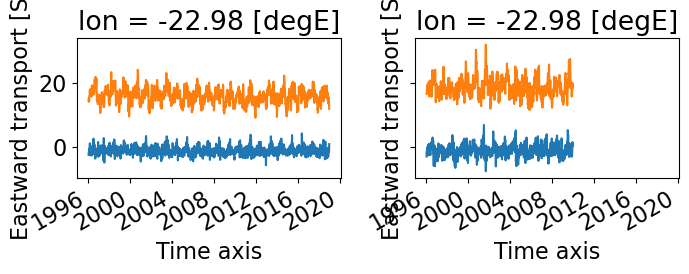

In [21]:
ax=T_sv.isel(lon=0).sel(lat=[-1.12,1.12],method='nearest').diff('lat').plot(x='time_counter',col='forcings')
EUC_JRA.T_30.sel(time_counter=T_sv.time_counter).sel(lon=-23,method='nearest').plot(ax=ax.axes.flat[0])
EUC_CORE.T_30.sel(time_counter=T_sv.time_counter.sel(time_counter=slice(None,'2009'))).sel(lon=-23,method='nearest').plot(ax=ax.axes.flat[1])
plt.tight_layout

/tmp/ipykernel_3118548/1550340580.py:2: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  NEUC_JRA.T_fixed.sel(time_counter=T_sv.time_counter).sel(lon=-23,method='nearest').plot(ax=ax.axes.flat[0])
/tmp/ipykernel_3118548/1550340580.py:3: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  NEUC_CORE.T_fixed.sel(time_counter=T_sv.time_counter.sel(time_counter=slice(None,'2009'))).sel(lon=-23,method='nearest').plot(ax=ax.axes.flat[1])


<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

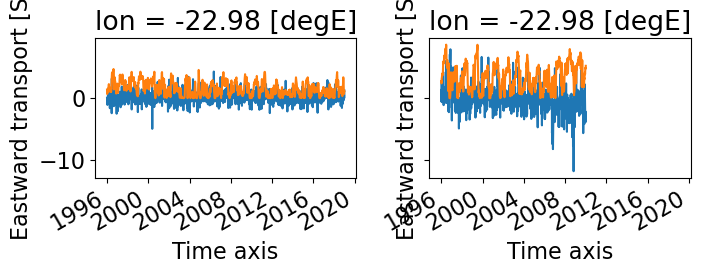

In [22]:
ax=T_sv.isel(lon=0).sel(lat=[4.25,5.25],method='nearest').diff('lat').plot(x='time_counter',col='forcings')
NEUC_JRA.T_fixed.sel(time_counter=T_sv.time_counter).sel(lon=-23,method='nearest').plot(ax=ax.axes.flat[0])
NEUC_CORE.T_fixed.sel(time_counter=T_sv.time_counter.sel(time_counter=slice(None,'2009'))).sel(lon=-23,method='nearest').plot(ax=ax.axes.flat[1])
plt.tight_layout

## monthly mean

In [23]:
def calc_mm_tau(ds_JRA):

    # upsample to daily for right weighting of monthly averages
    JRA_tau_ave_d = ds_JRA.resample({'time_counter':'1D'},closed = 'right',label='right',loffset='-60H').nearest(tolerance='2D')           

    # Calculate the weights
    w = 1/JRA_tau_ave_d.time_counter.dt.days_in_month

    # correct last weight (27-31 Dec = 5 days)
    w[-1] = 5/31

    # calulte monthly means weighted by days of each months
    return (JRA_tau_ave_d*w).resample(time_counter = 'MS').sum().compute()

In [24]:
T_EUC = xr.concat([EUC_JRA,EUC_CORE],
                        'forcings').T_30.sel(time_counter=T_sv.time_counter).sel(lon=-23.02,method='nearest')
T_EUC.coords['forcings'] = (['forcings'],['JRA','CORE'],)
T_sv_EUC = T_sv.isel(lon=0).sel(lat=[-1.12,1.12],method='nearest').diff('lat')

T_NEUC = xr.concat([NEUC_JRA,NEUC_CORE],
                        'forcings').T_fixed.sel(time_counter=T_sv.time_counter).sel(lon=-23.02,method='nearest')
T_NEUC.coords['forcings'] = (['forcings'],['JRA','CORE'],)
T_sv_NEUC = T_sv.isel(lon=0).sel(lat=slice(4.25,5.25)).mean('lat')

T_nSECu = xr.concat([nSECu_JRA,nSECu_CORE],
                        'forcings').INT.sel(time_counter=T_sv.time_counter).sel(lon=-23.02,method='nearest')
T_nSECu.coords['forcings'] = (['forcings'],['JRA','CORE'],)
T_sv_nSECu = T_sv.isel(lon=0).sel(lat=slice(0,5)).mean('lat')

In [25]:
T_NEUC_mm = calc_mm_tau(T_NEUC)
T_EUC_mm = calc_mm_tau(T_EUC)
T_sv_NEUC_mm = calc_mm_tau(T_sv_NEUC)
T_sv_EUC_mm = calc_mm_tau(T_sv_EUC)

/tmp/ipykernel_3118548/4285097236.py:4: FutureWarning: Following pandas, the `loffset` parameter to resample will be deprecated in a future version of xarray.  Switch to using time offset arithmetic.
  JRA_tau_ave_d = ds_JRA.resample({'time_counter':'1D'},closed = 'right',label='right',loffset='-60H').nearest(tolerance='2D')
/tmp/ipykernel_3118548/4285097236.py:4: FutureWarning: Following pandas, the `loffset` parameter to resample will be deprecated in a future version of xarray.  Switch to using time offset arithmetic.
  JRA_tau_ave_d = ds_JRA.resample({'time_counter':'1D'},closed = 'right',label='right',loffset='-60H').nearest(tolerance='2D')
/tmp/ipykernel_3118548/4285097236.py:4: FutureWarning: Following pandas, the `loffset` parameter to resample will be deprecated in a future version of xarray.  Switch to using time offset arithmetic.
  JRA_tau_ave_d = ds_JRA.resample({'time_counter':'1D'},closed = 'right',label='right',loffset='-60H').nearest(tolerance='2D')
/tmp/ipykernel_3118

## Correlation between Sverdrup transport and mooring timeseries to understand what can be explain by wind stress curl

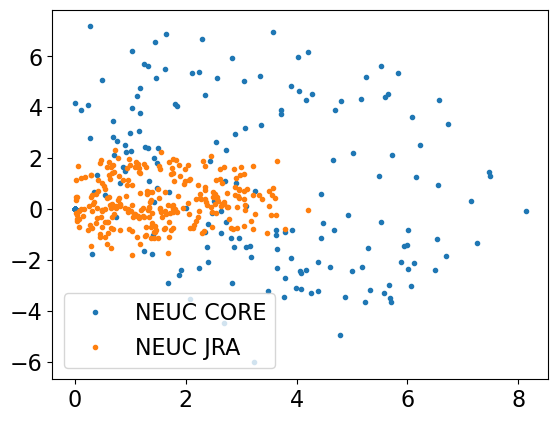

In [26]:
plt.plot(T_NEUC_mm.sel(forcings='CORE').values,T_sv_NEUC_mm.sel(forcings='CORE').values,'.',label='NEUC CORE')
plt.plot(T_NEUC_mm.sel(forcings='JRA').values,T_sv_NEUC_mm.sel(forcings='JRA').values,'.',label='NEUC JRA')
plt.legend()

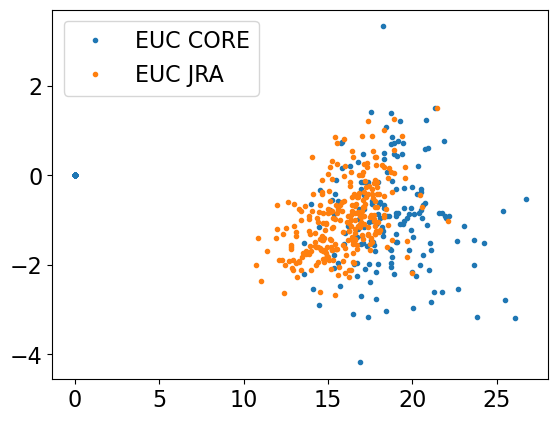

In [27]:
plt.plot(T_EUC_mm.sel(forcings='CORE').values,T_sv_EUC_mm.sel(forcings='CORE').values,'.',label='EUC CORE')
plt.plot(T_EUC_mm.sel(forcings='JRA').values,T_sv_EUC_mm.sel(forcings='JRA').values,'.',label='EUC JRA')
plt.legend()

### EUC

In [28]:
tlim = ['1996','2009']
r = xs.pearson_r(T_EUC_mm.sel(time_counter=slice(*tlim)), T_sv_EUC_mm.sel(time_counter=slice(*tlim)), dim='time_counter', skipna=True)
p = xs.pearson_r_eff_p_value(T_EUC_mm.sel(time_counter=slice(*tlim)), T_sv_EUC_mm.sel(time_counter=slice(*tlim)), dim='time_counter', skipna=True)
print('EUC')
print(tlim)
print(T_EUC_mm.forcings.values)
print(r.values)
print(p.values)

EUC
['1996', '2009']
['JRA' 'CORE']
[[ 0.47003208]
 [-0.03274258]]
[[1.35350561e-06]
 [7.29466667e-01]]


/gxfs_work/geomar/smomw294/.conda/envs/py3_std/lib/python3.9/site-packages/xskillscore/core/deterministic.py:462: UserWarning: ['time_counter'] is not 'time'. Make sure that you are applying this over a temporal dimension.
  warnings.warn(


In [29]:
tlim = ['2005','2018']
r = xs.pearson_r(T_EUC_mm.sel(time_counter=slice(*tlim)), T_sv_EUC_mm.sel(time_counter=slice(*tlim)), dim='time_counter', skipna=True)
p = xs.pearson_r_eff_p_value(T_EUC_mm.sel(time_counter=slice(*tlim)), T_sv_EUC_mm.sel(time_counter=slice(*tlim)), dim='time_counter', skipna=True)
print('EUC')
print(tlim)
print(T_EUC_mm.sel(forcings='JRA').forcings.values)
print(r.sel(forcings='JRA').values)
print(p.sel(forcings='JRA').values)

EUC
['2005', '2018']
JRA
[0.50725568]
[3.35612152e-07]


/gxfs_work/geomar/smomw294/.conda/envs/py3_std/lib/python3.9/site-packages/xskillscore/core/deterministic.py:462: UserWarning: ['time_counter'] is not 'time'. Make sure that you are applying this over a temporal dimension.
  warnings.warn(


### NEUC

In [30]:
tlim = ['1996','2009']
r = xs.pearson_r(T_NEUC_mm.sel(time_counter=slice(*tlim)), T_sv_NEUC_mm.sel(time_counter=slice(*tlim)), dim='time_counter', skipna=True)
p = xs.pearson_r_eff_p_value(T_NEUC_mm.sel(time_counter=slice(*tlim)), T_sv_NEUC_mm.sel(time_counter=slice(*tlim)), dim='time_counter', skipna=True)
print('NEUC')
print(tlim)
print(T_NEUC_mm.forcings.values)
print(r.values)
print(p.values)

NEUC
['1996', '2009']
['JRA' 'CORE']
[ 0.19617942 -0.28674381]
[0.06385983 0.05335252]


/gxfs_work/geomar/smomw294/.conda/envs/py3_std/lib/python3.9/site-packages/xskillscore/core/deterministic.py:462: UserWarning: ['time_counter'] is not 'time'. Make sure that you are applying this over a temporal dimension.
  warnings.warn(


In [31]:
tlim = ['2001','2009']
r = xs.pearson_r(T_NEUC_mm.sel(time_counter=slice(*tlim)), T_sv_NEUC_mm.sel(time_counter=slice(*tlim)), dim='time_counter', skipna=True)
p = xs.pearson_r_eff_p_value(T_NEUC_mm.sel(time_counter=slice(*tlim)), T_sv_NEUC_mm.sel(time_counter=slice(*tlim)), dim='time_counter', skipna=True)
print('NEUC')
print(tlim)
print(T_NEUC_mm.forcings.values)
print(r.values)
print(p.values)

NEUC
['2001', '2009']
['JRA' 'CORE']
[ 0.1644339  -0.27022667]
[0.20539094 0.16430273]


/gxfs_work/geomar/smomw294/.conda/envs/py3_std/lib/python3.9/site-packages/xskillscore/core/deterministic.py:462: UserWarning: ['time_counter'] is not 'time'. Make sure that you are applying this over a temporal dimension.
  warnings.warn(


In [32]:
tlim = ['2010','2018']
r = xs.pearson_r(T_NEUC_mm.sel(time_counter=slice(*tlim)), T_sv_NEUC_mm.sel(time_counter=slice(*tlim)), dim='time_counter', skipna=True)
p = xs.pearson_r_eff_p_value(T_NEUC_mm.sel(time_counter=slice(*tlim)), T_sv_NEUC_mm.sel(time_counter=slice(*tlim)), dim='time_counter', skipna=True)
print('NEUC')
print(tlim)
print(T_NEUC_mm.sel(forcings='JRA').forcings.values)
print(r.sel(forcings='JRA').values)
print(p.sel(forcings='JRA').values)

NEUC
['2010', '2018']
JRA
-0.15003373906862594
0.29332515478123916


/gxfs_work/geomar/smomw294/.conda/envs/py3_std/lib/python3.9/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/gxfs_work/geomar/smomw294/.conda/envs/py3_std/lib/python3.9/site-packages/xskillscore/core/deterministic.py:462: UserWarning: ['time_counter'] is not 'time'. Make sure that you are applying this over a temporal dimension.
  warnings.warn(
/gxfs_work/geomar/smomw294/.conda/envs/py3_std/lib/python3.9/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/gxfs_work/geomar/smomw294/.conda/envs/py3_std/lib/python3.9/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/gxfs_work/geomar/smomw294/.conda/envs/py3_std/lib/python3.9/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den


# Monthly means
run notebook up to selected cell [16], then run all below this cell

In [33]:
in_dir_global_mm = Path('../')
in_dir_data_mm = 'data/INALT20_wind_forcing_comparison'
JRA_exp_id_mm = "INALT20.L46-KFS10?"
CORE_exp_id_mm = "INALT20.L46-KFS044"
nest_prefix_mm = "1_"
lat_lim=[-6,7.98]
lon_lims = [-40,-35,-30,-25,-20,-15]

# chunk sizes
chu_x = 100 # None means take the full dataset
chu_y = 100
chu_z = 1
chu_t = 12

# 1_INALT20.L46-KFS044_mm_19870101_19871231_windstress_10S10N_65W15E_grid_U.nc
JRA_file_y = list(sorted(
    Path(in_dir_global_mm).glob(
        f"{in_dir_data_mm}_tauy/{nest_prefix_mm}{JRA_exp_id_mm}*_windstress_10S10N_65W15E_grid_V.nc")))
JRA_file_x = list(sorted(
    Path(in_dir_global_mm).glob(
        f"{in_dir_data_mm}_taux/{nest_prefix_mm}{JRA_exp_id_mm}*_windstress_10S10N_65W15E_grid_U.nc")))
CORE_file_y = list(sorted(
    Path(in_dir_global_mm).glob(
        f"{in_dir_data_mm}_tauy/{nest_prefix_mm}{CORE_exp_id_mm}*_windstress_10S10N_65W15E_grid_V.nc")))
CORE_file_x = list(sorted(
    Path(in_dir_global_mm).glob(
        f"{in_dir_data_mm}_taux/{nest_prefix_mm}{CORE_exp_id_mm}*_windstress_10S10N_65W15E_grid_U.nc")))

print(f"Found {len(JRA_file_y)} JRA Y files, {len(JRA_file_x)} JRA X files, {len(CORE_file_y)} CORE Y files, {len(CORE_file_x)} CORE X files")

Found 61 JRA Y files, 61 JRA X files, 52 CORE Y files, 52 CORE X files


In [34]:
def load_mm_data(JRA_file,CORE_file,ds_mesh,lat_lim,grid):
#     JRA_file,CORE_file,ds_mesh,lat_lim,grid = JRA_file_y,CORE_file_y,ds_mesh,lat_lim,'V'
    ds_JRA = (xr.open_mfdataset(
            JRA_file,
            combine='by_coords',
        chunks={"time_counter":chu_t, 
              "lat":chu_y,"lon":chu_x},
            decode_cf=True)).sel(lat=slice(*lat_lim),lon=slice(-41,None))

    
    ds_CORE = (xr.open_mfdataset(
            CORE_file,
            combine='by_coords',
            decode_cf=True,
        chunks={"time_counter":chu_t, 
              "lat":chu_y,"lon":chu_x},
        )).sel(lat=slice(*lat_lim),lon=slice(-41,None))
    ds_CORE.coords['time_counter']=ds_JRA.sel(time_counter=slice(None,'2009')).time_counter

    with xr.set_options(keep_attrs=True):
        ds = xr.concat([ds_JRA,ds_CORE],
                        'forcings')

    ds.coords['forcings'] = (['forcings'],['JRA','CORE'],)

    x_lims = ds_JRA.lon.isel(lon=[0,-1]).values
    y_lims = ds_JRA.lat.isel(lat=[0,-1]).values



    if grid=='U':
        ds.coords['x'] = ds_taux1.x.sel(lon=slice(*x_lims))
        ds.coords['y'] = ds_taux1.y.sel(lat=slice(*y_lims))
        ds['e2u'] = ds_mesh.sel(x=ds.x,y=ds.y).e2u.squeeze()
    elif grid=='V':
        ds.coords['x'] = ds_tauy1.x.sel(lon=slice(*x_lims))
        ds.coords['y'] = ds_tauy1.y.sel(lat=slice(*y_lims))
        ds['e1v'] = ds_mesh.sel(x=ds.x,y=ds.y).e1v.squeeze()

    return ds

In [35]:
ds_tauy_mm = load_mm_data(JRA_file_y,CORE_file_y,ds_mesh,lat_lim,'V')
ds_taux_mm = load_mm_data(JRA_file_x,CORE_file_x,ds_mesh,lat_lim,'U')

/gxfs_work/geomar/smomw294/.conda/envs/py3_std/lib/python3.9/site-packages/dask/array/core.py:4836: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
/gxfs_work/geomar/smomw294/.conda/envs/py3_std/lib/python3.9/site-packages/dask/array/core.py:4836: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(


In [36]:
%%time
fn = Path(out_dir_data+'tau_curl_MM_1958_2018.nc')
if fn.is_file():
    print('Load existing file')
    tau_curl=xr.open_dataarray(fn,
        chunks={"time_counter":chu_t, 
              "lat":chu_y,"lon":chu_x},)
else:
    print('Cal wind stress curl')
    dtaux_dy = ds_taux_mm.taux.diff('lat')/ds_taux_mm.e2u.isel(
            lat=slice(1,ds_taux_mm.diff('lat').lat.size+1))
    dtauy_dx = ds_tauy_mm.tauy.diff('lon')/ds_tauy_mm.e1v.isel(
            lon=slice(1,ds_tauy_mm.diff('lon').lon.size+1))


    dtaux_dy.coords['lat'] = dtauy_dx.lat
    dtauy_dx.coords['lon'] = dtaux_dy.lon
    tau_curl= dtauy_dx - dtaux_dy

    tau_curl.coords['fmask']=(ds_mesh.fmaskutil.squeeze()).isel(x=tau_curl.x,y=tau_curl.y)
    tau_curl.coords['e2u']=(ds_mesh.e2u.squeeze()).isel(x=tau_curl.x,y=tau_curl.y)
    tau_curl = tau_curl.where(tau_curl.fmask).compute()
    tau_curl.to_netcdf(fn)
    

Load existing file
CPU times: user 23.3 ms, sys: 8.22 ms, total: 31.5 ms
Wall time: 156 ms


/gxfs_work/geomar/smomw294/.conda/envs/py3_std/lib/python3.9/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/gxfs_work/geomar/smomw294/.conda/envs/py3_std/lib/python3.9/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


In [37]:
def calc_sv(tau_curl,e2u):
    rho=1025;
    Omega,R_earth = 7.271e-5,6.37e6
    beta=(2*Omega*np.cos(tau_curl.lat*(np.pi/180)))/R_earth
    T_sv_A=-(tau_curl/(rho*beta))*e2u
    return (T_sv_A.isel(lon=slice(None, None, -1)
            ).cumsum('lon')).isel(lon=slice(None, None, -1)
            ).where(tau_curl.notnull())*1e-6

In [38]:
TSV_mm = calc_sv(tau_curl.where(tau_curl.fmask),tau_curl.e2u.where(tau_curl.fmask))
TSV_mm

<xarray.DataArray (forcings: 2, time_counter: 732, lat: 280, lon: 1088)>
dask.array<mul, shape=(2, 732, 280, 1088), dtype=float64, chunksize=(2, 12, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1958-01-01 ... 2018-12-01
  * lat           (lat) float32 -5.964 -5.914 -5.865 -5.815 ... 7.85 7.9 7.949
  * lon           (lon) float32 -40.97 -40.92 -40.88 ... 13.27 13.32 13.38
    vmask         (lat, lon) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
  * forcings      (forcings) <U4 'JRA' 'CORE'
    x             (lon) int64 480 481 482 483 484 ... 1563 1564 1565 1566 1567
    y             (lat) int64 dask.array<chunksize=(100,), meta=np.ndarray>
    umask         (lat, lon) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    fmask         (lat, lon) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    e2u           (lat, lon) float64 5.53e+03 5.53e+03 ... 5.507e+03 5.507e+03

# EUC mean \psi 2S-\PSI 2S 

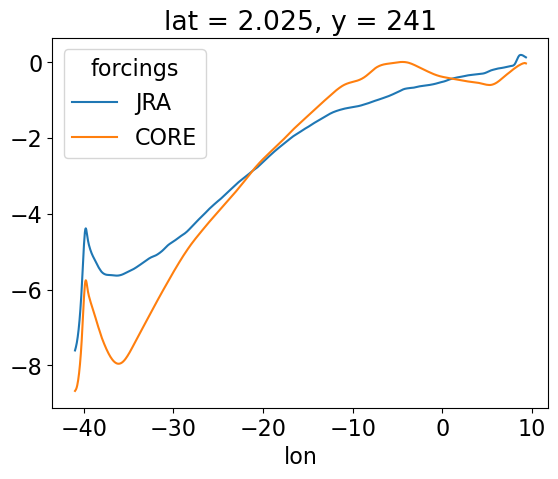

In [39]:
TSV_mm.sel(time_counter=slice('1980','2009')).mean('time_counter').sel(lat=[-2,2],method='nearest').diff('lat').plot(x='lon',hue='forcings')

In [40]:
TSV_mm.sel(time_counter=slice('1980','2009')).mean('time_counter').sel(lat=[-2,2],lon=[-35,-23,-10,0],method='nearest').diff('lat').values

array([[[-5.51700797, -3.2103777 , -1.17610182, -0.51089363]],

       [[-7.69205939, -3.39206134, -0.51130699, -0.37959497]]])

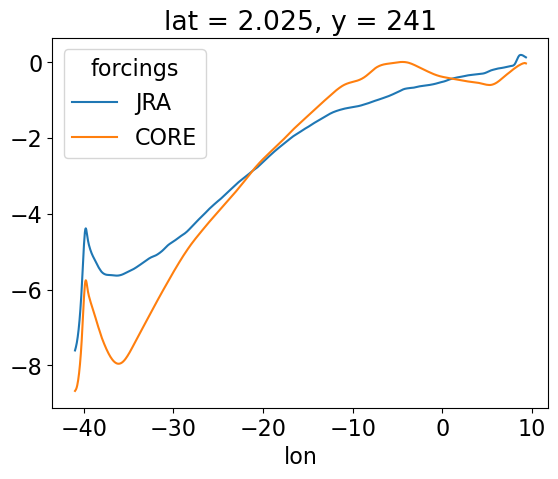

In [41]:
TSV_mm.sel(time_counter=slice('1980','2009')).mean('time_counter').sel(lat=[-2,2],method='nearest').diff('lat').plot(x='lon', hue='forcings')

In [42]:
TSV_mm.sel(time_counter=slice('1980','2009')).mean('time_counter').sel(lat=[-2,2],method='nearest').diff('lat').values

2023-12-11 17:17:47,308 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


array([[[-7.60319393, -7.56041113, -7.51393672, ...,         nan,
                 nan,         nan]],

       [[-8.67198138, -8.65551401, -8.63556588, ...,         nan,
                 nan,         nan]]])

In [43]:
tsv_mm_clim = TSV_mm.sel(time_counter=slice('1980','2009')).groupby('time_counter.month').mean('time_counter')

In [44]:
tsv_mmA = TSV_mm.groupby('time_counter.month')-tsv_mm_clim

/gxfs_work/geomar/smomw294/.conda/envs/py3_std/lib/python3.9/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 61 times more chunks
  return self.array[key]


In [45]:
tsv_mmA.sel(forcings='JRA').squeeze()

<xarray.DataArray (time_counter: 732, lat: 280, lon: 1088)>
dask.array<getitem, shape=(732, 280, 1088), dtype=float64, chunksize=(1, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1958-01-01 ... 2018-12-01
  * lat           (lat) float32 -5.964 -5.914 -5.865 -5.815 ... 7.85 7.9 7.949
  * lon           (lon) float32 -40.97 -40.92 -40.88 ... 13.27 13.32 13.38
    vmask         (lat, lon) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    forcings      <U4 'JRA'
    x             (lon) int64 480 481 482 483 484 ... 1563 1564 1565 1566 1567
    y             (lat) int64 dask.array<chunksize=(100,), meta=np.ndarray>
    umask         (lat, lon) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    fmask         (lat, lon) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    e2u           (lat, lon) float64 5.53e+03 5.53e+03 ... 5.507e+03 5.507e+03
    month         (time_counter) int64 1 2 3 4 5 6 7 8 9 ... 5 6 7 8 9 10 11 12

2023-12-11 17:17:51,663 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-12-11 17:17:54,581 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-12-11 17:17:56,589 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-12-11 17:17:58,539 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


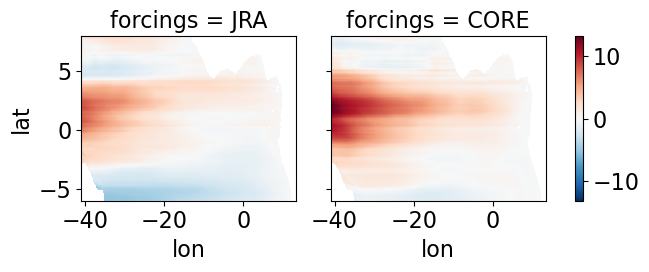

In [46]:
tsv_mmA.isel(time_counter=0).plot(x='lon',col='forcings')

In [47]:
# row = f'$\Psi$({lat[i+1]}°N - $\Psi$({lat[i]}°N)'\(for i in len(lats))

# cols = ['Column {}'.format(col) for col in range(1, 4)]
# rows = ['Row {}'.format(row) for row in ['A', 'B', 'C', 'D']]

In [48]:
lats = [-6,-4,-2,2,4,6,8]
lons = [-35,-25,-15]

rows = [r'6°S to 4°S',
        r'4°S to 2°S',
        r'2°S to 2°N',
        r'2°N to 4°N',
        r'4°N to 6°N',
        r'6°N to 8°N']

rows_n = [r'SEUC',
        r'cSEC',
        r'EUC',
        r'nSEC',
        r'NEUC',
        r'NECC']

In [49]:
T_zonal = (tsv_mmA.sel(lat=lats,lon=lons,method='nearest').resample(time_counter='1Y').mean()).diff('lat').compute()
T_zonal.coords['lat']=rows

2023-12-11 17:18:06,574 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-12-11 17:18:10,626 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-12-11 17:18:12,435 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-12-11 17:18:13,854 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-12-11 17:18:15,462 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-12-11 17:18:17,412 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-12-11 17:18:19,989 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-12-11 17:18:22,664 - distributed.utils_perf - WARNING - full garbage collections took

In [50]:
T_zonal = xr.concat([T_zonal.sel(forcings='CORE').squeeze(),
                T_zonal.sel(forcings='JRA').squeeze()],
                'forcings')

In [51]:
lats2 = [-1.5,1.5,4,8]
lons2 = [-35,-25,-15]

rows2 = [r'1.5°S to 1.5°N',
        r'1.5°N to 4°N',
        r'4°N to 8°N']

rows_n2 = [r'EUC',
        r'nSEC',
        r'NECC']

T_zonal2 = (tsv_mmA.sel(lat=lats2,lon=lons2,method='nearest').resample(time_counter='1Y').mean()).diff('lat').compute()
T_zonal2.coords['lat']=rows2
T_zonal2 = xr.concat([T_zonal2.sel(forcings='CORE').squeeze(),
                T_zonal2.sel(forcings='JRA').squeeze()],
                'forcings')

2023-12-11 17:18:57,505 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-12-11 17:18:59,293 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-12-11 17:19:01,144 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-12-11 17:19:02,595 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-12-11 17:19:04,353 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-12-11 17:19:06,465 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-12-11 17:19:08,208 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-12-11 17:19:10,377 - distributed.utils_perf - WARNING - full garbage collections took

In [52]:
lats3 = [-1.5,1.5,4,8]
lons3 = [-35,-25,-15]

rows3 = [r'4°S to 0°N',
        r'0°N to 5°N',
        r'5°N to 8°N']

rows_n3 = [r'cSEC/EUC',
        r'nSEC',
        r'NECC']

T_zonal3 = (tsv_mmA.sel(lat=lats3,lon=lons3,method='nearest').resample(time_counter='1Y').mean()).diff('lat').compute()
T_zonal3.coords['lat']=rows3
T_zonal3 = xr.concat([T_zonal3.sel(forcings='CORE').squeeze(),
                T_zonal3.sel(forcings='JRA').squeeze()],
                'forcings')

2023-12-11 17:19:48,056 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-12-11 17:19:49,472 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-12-11 17:19:51,400 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-12-11 17:19:53,005 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-12-11 17:19:55,317 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-12-11 17:19:57,690 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-12-11 17:19:59,776 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-12-11 17:20:02,125 - distributed.utils_perf - WARNING - full garbage collections took

/tmp/ipykernel_3118548/284802396.py:7: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  im.axes[0,idx].plot(T_zonal2.time_counter,T_zonal2.sel(forcings='CORE').isel(lat=-1,lon=idx),'--',color='C0',linewidth=.8)
/tmp/ipykernel_3118548/284802396.py:8: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  im.axes[0,idx].plot(T_zonal2.time_counter,T_zonal2.sel(forcings='JRA').isel(lat=-1,lon=idx),'--',color='C1',linewidth=.8)
/tmp/ipykernel_3118548/284802396.py:9: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in im.axes.flat:
/tmp/ipykernel_3118548/284802396.py:17: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax, row in zip(im.axes[:,0], rows_n):
/tmp/ipy

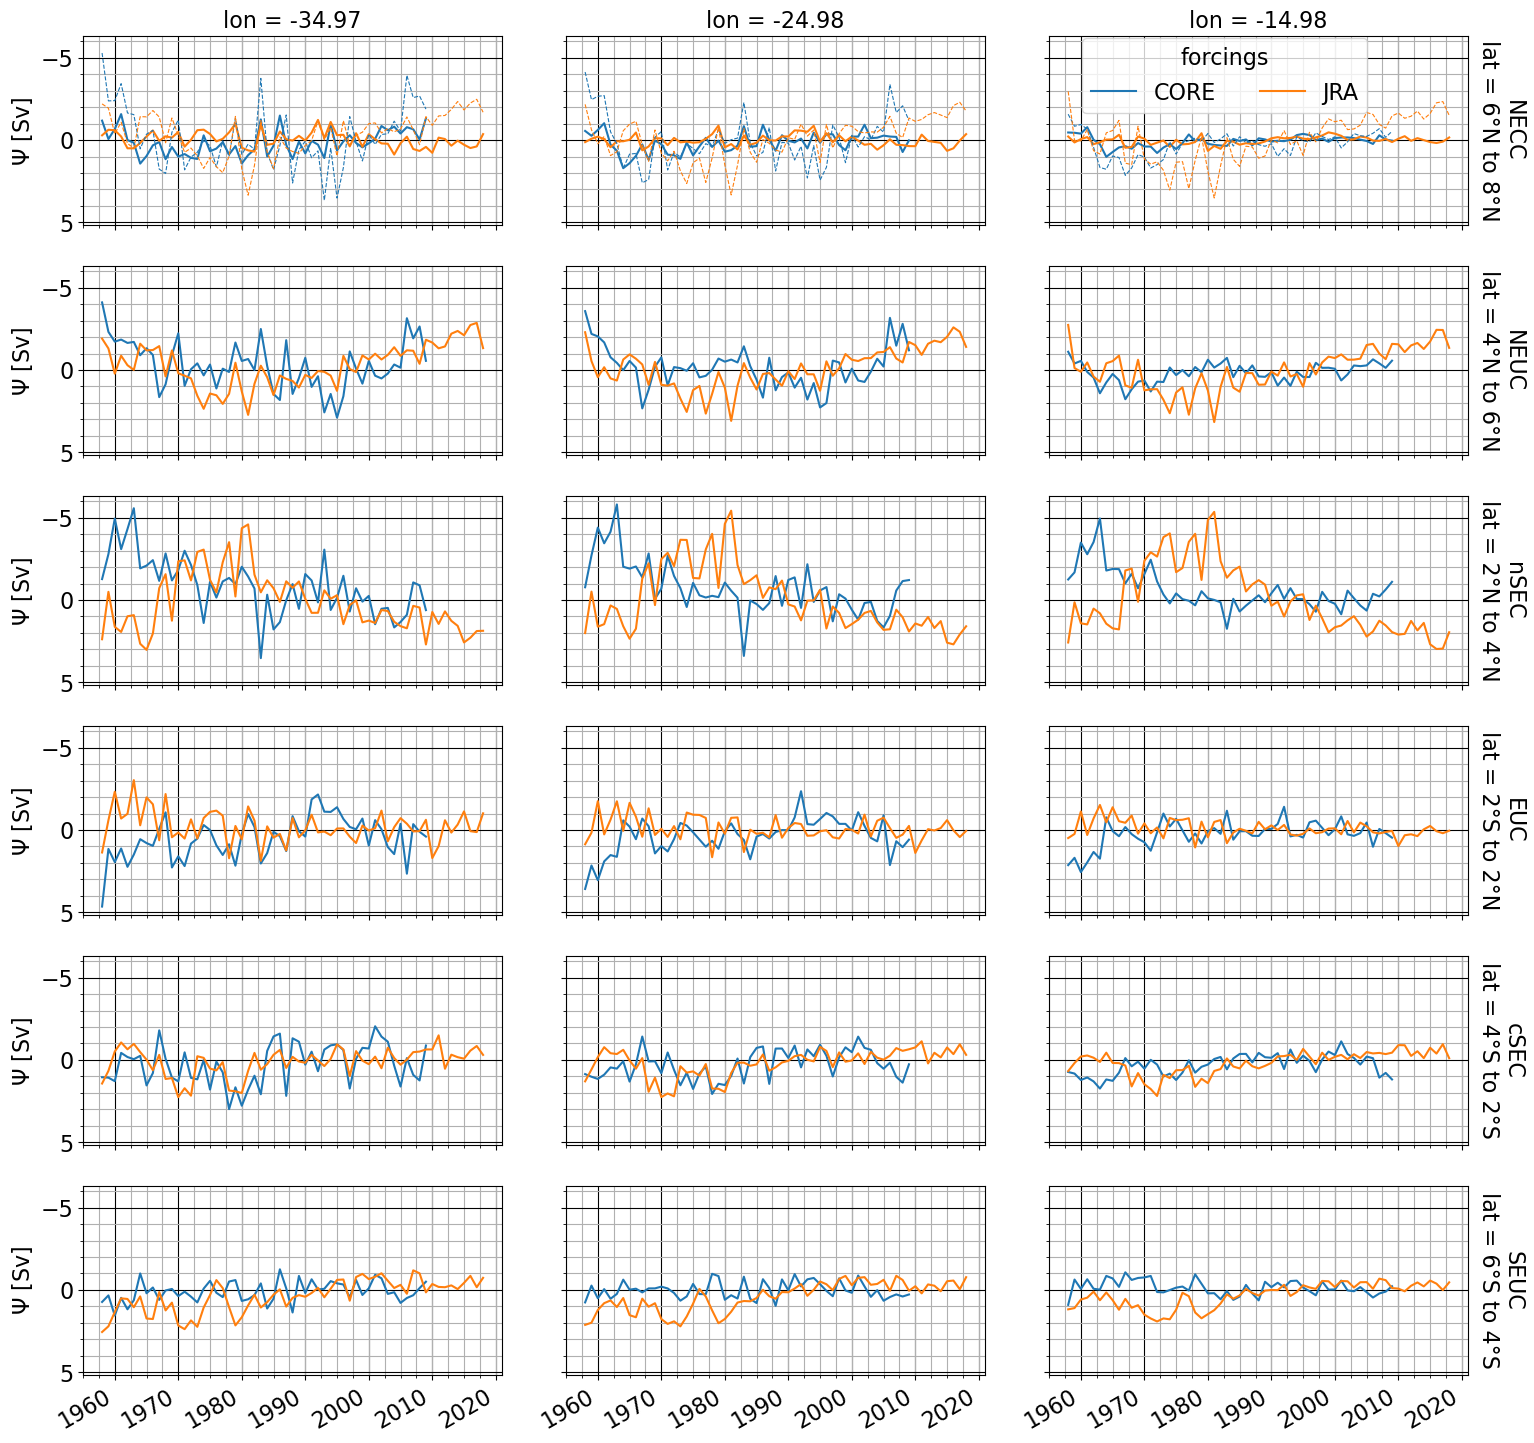

In [53]:
im = T_zonal.reindex(lat=T_zonal.lat[::-1]).plot(hue='forcings',col='lon',row='lat',
                                                      yincrease=False,add_legend=False,
                                                      figsize=[15,15])
for idx,lon in enumerate(T_zonal2.lon):
#     T_zonal2.sel(forcings='CORE').isel(lat=-1,lon=idx).plot.line('--',color='C0',ax=im.axes[0,idx],linewidth=.8)
#     T_zonal2.sel(forcings='JRA').isel(lat=-1,lon=idx).plot.line('--',color='C1',ax=im.axes[0,idx],linewidth=.8)
    im.axes[0,idx].plot(T_zonal2.time_counter,T_zonal2.sel(forcings='CORE').isel(lat=-1,lon=idx),'--',color='C0',linewidth=.8)
    im.axes[0,idx].plot(T_zonal2.time_counter,T_zonal2.sel(forcings='JRA').isel(lat=-1,lon=idx),'--',color='C1',linewidth=.8)
for ax in im.axes.flat:
    ax.grid(which='major',color='k')
    ax.grid(which='minor')
    ax.minorticks_on()
    ax.set_xlabel('')
    ax.set_xticks(['1961-01-01','1971-01-01','1981-01-01','1991-01-01','2001-01-01','2011-01-01','2021-01-01'])
    ax.set_xticklabels(['1960','1970','1980','1990','2000','2010','2020'])
pad = 5 # in points    
for ax, row in zip(im.axes[:,0], rows_n):
    ax.set_ylabel('$\Psi$ [Sv]')
for ax, row in zip(im.axes[:,-1], rows_n[::-1]):
    ax.annotate(row, xy=(1, 0.5), xytext=(350, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                 ha='right', va='center',rotation=-90,)
im.add_legend(bbox_to_anchor=(0.77, 0.94),ncol=2)
plt.savefig((Path(out_dir_fig) / "1_INALT20_Sv_psi_ts_lat_bands.png"),dpi=300,bbox_inches='tight')

/tmp/ipykernel_3118548/4067410026.py:4: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in im.axes.flat:
/tmp/ipykernel_3118548/4067410026.py:10: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax, row in zip(im.axes[:,0], rows_n2):
/tmp/ipykernel_3118548/4067410026.py:12: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax, row in zip(im.axes[:,-1], rows_n2[::-1]):


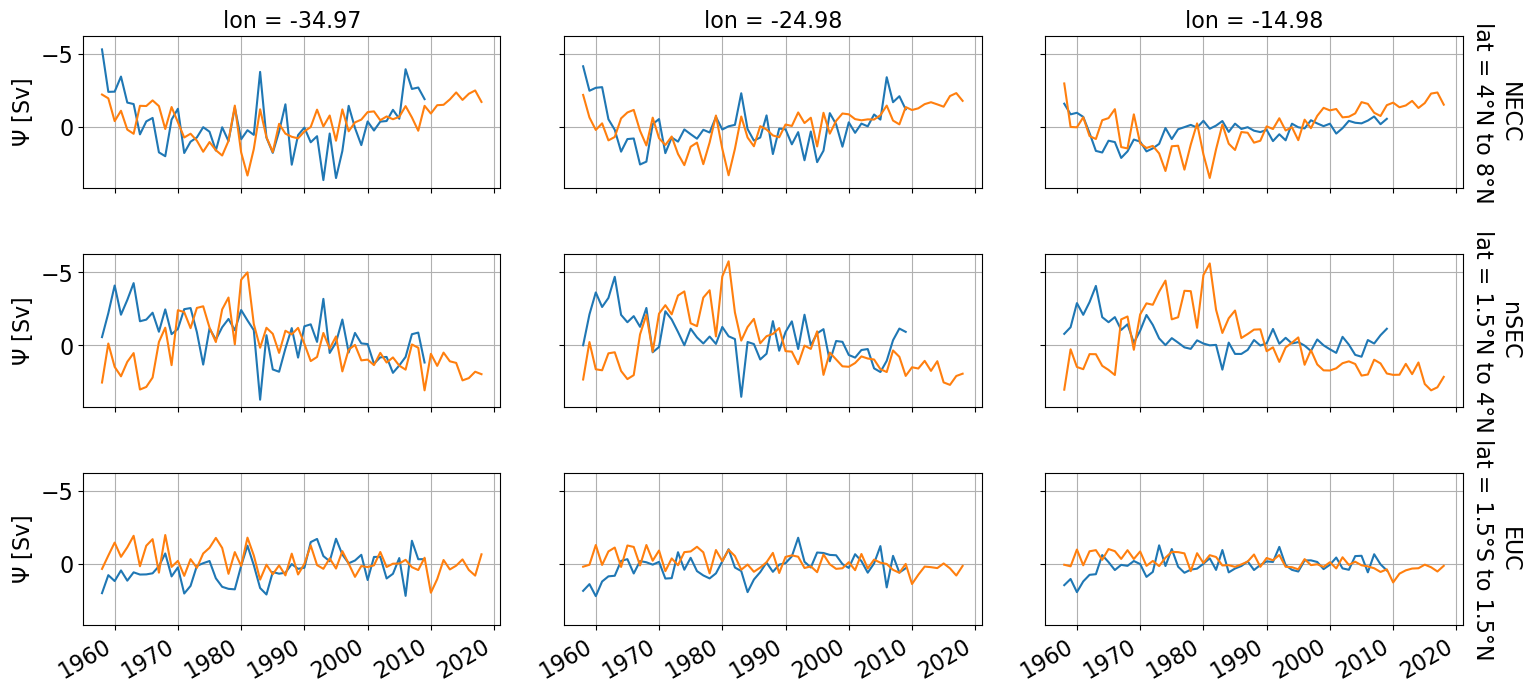

In [54]:
im = T_zonal2.reindex(lat=T_zonal2.lat[::-1]).plot(hue='forcings',col='lon',row='lat',
                                                      yincrease=False,add_legend=False,
                                                      figsize=[15,15/2])
for ax in im.axes.flat:
    ax.grid()
    ax.set_xlabel('')
    ax.set_xticks(['1961-01-01','1971-01-01','1981-01-01','1991-01-01','2001-01-01','2011-01-01','2021-01-01'])
    ax.set_xticklabels(['1960','1970','1980','1990','2000','2010','2020'])
pad = 5 # in points    
for ax, row in zip(im.axes[:,0], rows_n2):
    ax.set_ylabel('$\Psi$ [Sv]')
for ax, row in zip(im.axes[:,-1], rows_n2[::-1]):
    ax.annotate(row, xy=(1, 0.5), xytext=(350, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                 ha='right', va='center',rotation=-90,)
# im.add_legend(bbox_to_anchor=(0.52, 0.94),ncol=2)
plt.savefig((Path(out_dir_fig) / "1_INALT20_Sv_psi_ts_EUC_NECC.png"),dpi=300,bbox_inches='tight')

/tmp/ipykernel_3118548/594685114.py:4: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in im.axes.flat:
/tmp/ipykernel_3118548/594685114.py:10: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax, row in zip(im.axes[:,0], rows_n3):
/tmp/ipykernel_3118548/594685114.py:12: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax, row in zip(im.axes[:,-1], rows_n3[::-1]):


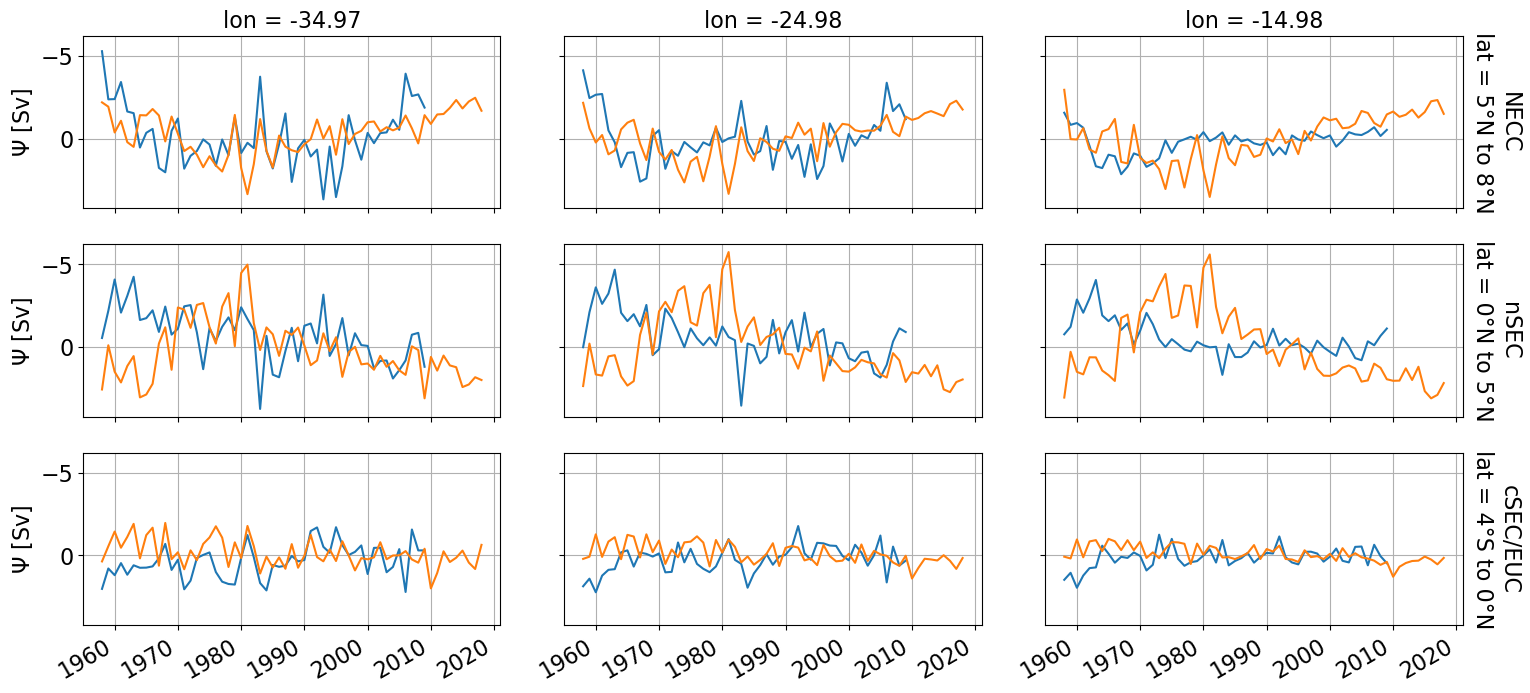

In [55]:
im = T_zonal3.reindex(lat=T_zonal3.lat[::-1]).plot(hue='forcings',col='lon',row='lat',
                                                      yincrease=False,add_legend=False,
                                                      figsize=[15,15/2])
for ax in im.axes.flat:
    ax.grid()
    ax.set_xlabel('')
    ax.set_xticks(['1961-01-01','1971-01-01','1981-01-01','1991-01-01','2001-01-01','2011-01-01','2021-01-01'])
    ax.set_xticklabels(['1960','1970','1980','1990','2000','2010','2020'])
pad = 5 # in points    
for ax, row in zip(im.axes[:,0], rows_n3):
    ax.set_ylabel('$\Psi$ [Sv]')
for ax, row in zip(im.axes[:,-1], rows_n3[::-1]):
    ax.annotate(row, xy=(1, 0.5), xytext=(350, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                 ha='right', va='center',rotation=-90,)
# im.add_legend(bbox_to_anchor=(0.52, 0.94),ncol=2)
plt.savefig((Path(out_dir_fig) / "1_INALT20_Sv_psi_ts_nSEC.png"),dpi=300,bbox_inches='tight')

In [56]:
def correlation(y1_ds,y2_ds):
    y1=y1_ds.values
    y2=y2_ds.values
    npts = len(y1_ds)
    lags = np.arange(-npts + 1, npts)
    ccov = np.correlate(y1 - y1.mean(), y2 - y2.mean(), mode='full')
    ccor = ccov / (npts * y1.std() * y2.std())

    fig, axs = plt.subplots(ncols=2,figsize=[20,3])
    fig.subplots_adjust(hspace=0.4)
    ax = axs[0]
    ax.plot(y1_ds.year, y1, 'b', label='y1')
    add_ax = axs[0].twinx()
    add_ax.plot(y2_ds.year, y2, 'r', label='y2')
    ax.set_ylim([-.03,.03])
    add_ax.set_ylim(-3, 3)
    ax.legend(loc='upper right', fontsize='small', ncol=2)
    ax.grid()

    ax = axs[1]
    ax.plot(lags, ccor)
    ax.set_ylim(-.5, 1)
    ax.set_ylabel('cross-correlation')
    ax.set_xlabel('lag of y1 relative to y2')
    ax.grid()

    maxlag = lags[np.argmax(np.abs(ccor))]
    print(f"max correlation {np.max(np.abs(ccor))} is at lag {maxlag}")
    print(f"max correlation {ccor[int(npts-1)]} is at lag {lags[int(npts-1)]}")

# Coarse resolution

In [58]:
in_dir_global_mm = Path('../')
in_dir_data_mm = 'data/INALT20_wind_forcing_comparison'
JRA_exp_id_mm = "INALT20.L46-KFS10?"
CORE_exp_id_mm = "INALT20.L46-KFS044"
nest_prefix_mm = "2deg_"
lat_lim=[-6,7.98]
lon_lims = [-40,-35,-30,-25,-20,-15]

# chunk sizes
chu_x = 100 # None means take the full dataset
chu_y = 100
chu_z = 1
chu_t = 12

# 1_INALT20.L46-KFS044_mm_19870101_19871231_windstress_10S10N_65W15E_grid_U.nc
JRA_file_y = list(sorted(
    Path(in_dir_global_mm).glob(
        f"{in_dir_data_mm}_tauy/{nest_prefix_mm}{JRA_exp_id_mm}*_windstress_10S10N_65W15E_grid_V.nc")))
JRA_file_x = list(sorted(
    Path(in_dir_global_mm).glob(
        f"{in_dir_data_mm}_taux/{nest_prefix_mm}{JRA_exp_id_mm}*_windstress_10S10N_65W15E_grid_U.nc")))
CORE_file_y = list(sorted(
    Path(in_dir_global_mm).glob(
        f"{in_dir_data_mm}_tauy/{nest_prefix_mm}{CORE_exp_id_mm}*_windstress_10S10N_65W15E_grid_V.nc")))
CORE_file_x = list(sorted(
    Path(in_dir_global_mm).glob(
        f"{in_dir_data_mm}_taux/{nest_prefix_mm}{CORE_exp_id_mm}*_windstress_10S10N_65W15E_grid_U.nc")))

print(f"Found {len(JRA_file_y)} JRA Y files, {len(JRA_file_x)} JRA X files, {len(CORE_file_y)} CORE Y files, {len(CORE_file_x)} CORE X files")

Found 61 JRA Y files, 61 JRA X files, 52 CORE Y files, 52 CORE X files


In [59]:
def load_mm_data(JRA_file,CORE_file,ds_mesh,lat_lim,grid):
#     JRA_file,CORE_file,ds_mesh,lat_lim,grid = JRA_file_y,CORE_file_y,ds_mesh,lat_lim,'V'
    ds_JRA = (xr.open_mfdataset(
            JRA_file,
            combine='by_coords',
        chunks={"time_counter":chu_t, 
              "lat":chu_y,"lon":chu_x},
            decode_cf=True))

    
    ds_CORE = (xr.open_mfdataset(
            CORE_file,
            combine='by_coords',
            decode_cf=True,
        chunks={"time_counter":chu_t, 
              "lat":chu_y,"lon":chu_x},
        ))
    ds_CORE.coords['time_counter']=ds_JRA.sel(time_counter=slice(None,'2009')).time_counter

    with xr.set_options(keep_attrs=True):
        ds = xr.concat([ds_JRA,ds_CORE],
                        'forcings')

    ds.coords['forcings'] = (['forcings'],['JRA','CORE'],)

    return ds

In [60]:
ds_tauy_mm = load_mm_data(JRA_file_y,CORE_file_y,ds_mesh,lat_lim,'V').sel(lat=slice(-10,10))
ds_taux_mm = load_mm_data(JRA_file_x,CORE_file_x,ds_mesh,lat_lim,'U')

In [61]:
ds_tauy_mm = ds_tauy_mm.where(ds_tauy_mm.vmask)
ds_taux_mm = ds_taux_mm.where(ds_taux_mm.umask)

In [62]:
lat_mx, lon_mx = xr.broadcast(ds_taux_mm.lat, ds_taux_mm.lon)

dy_taux = xr.apply_ufunc(
    gsw.distance,
    lon_mx,lat_mx,0,
    input_core_dims=[["lat"], ["lat"], []],  # list with one entry per arg
    output_core_dims=[["lat"]],  # returned data has one dimension
    exclude_dims=set(("lat",)),  # dimensions allowed to change size. Must be set!
    vectorize=True,  # loop over non-core dims
    )[0,0]

In [63]:
lat_my, lon_my = xr.broadcast(ds_tauy_mm.lat, ds_tauy_mm.lon)
dx_tauy = xr.apply_ufunc(
    gsw.distance,
    lon_my,lat_my,0,
    input_core_dims=[["lon"], ["lon"], []],  # list with one entry per arg
    output_core_dims=[["lon"]],  # returned data has one dimension
    exclude_dims=set(("lon",)),  # dimensions allowed to change size. Must be set!
    vectorize=True,  # loop over non-core dims
    )


In [64]:
lon = (ds_tauy_mm.lon.isel(lon=slice(None,-1)).values+ds_tauy_mm.lon.isel(lon=slice(1,None)).values)/2
lat = (ds_tauy_mm.lat.isel(lat=slice(None,-1)).values+ds_tauy_mm.lat.isel(lat=slice(1,None)).values)/2
forcings=ds_taux_mm.forcings
time_counter=ds_taux_mm.time_counter

In [65]:
%%time
fn = Path(out_dir_data+'tau_curl_MM_1958_2018.nc')
# if fn.is_file():
#     print('Load existing file')
#     tau_curl=xr.open_dataarray(fn,
#         chunks={"time_counter":chu_t, 
#               "lat":chu_y,"lon":chu_x},)
# else:
print('Cal wind stress curl')
dtaux_dy = ds_taux_mm.taux.diff('lat')/dy_taux
dtauy_dx = ds_tauy_mm.tauy.diff('lon')/dx_tauy

ds = (dtaux_dy.isel(lon=slice(None,-1)).values+dtaux_dy.isel(lon=slice(1,None)).values)/2
dtaux_dy_da = xr.DataArray(
    data=ds,
    dims=dtaux_dy.dims,
    coords=dict(
        lon=(['lon'], lon),
        lat=(['lat'], lat),
        time_counter=time_counter,
        forcings=forcings,
    ),
)

ds = (dtauy_dx.isel(lat=slice(None,-1)).values+dtauy_dx.isel(lat=slice(1,None)).values)/2
dtauy_dx_da = xr.DataArray(
    data=ds,
    dims=dtauy_dx.dims,
    coords=dict(
        lon=(['lon'], lon),
        lat=(['lat'], lat),
        time_counter=time_counter,
        forcings=forcings,
    ),
)

tau_curl= dtauy_dx - dtaux_dy

display(tau_curl)

Cal wind stress curl


2023-12-11 17:28:48,028 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


<xarray.DataArray (forcings: 2, lat: 9, lon: 38, time_counter: 732)>
dask.array<sub, shape=(2, 9, 38, 732), dtype=float64, chunksize=(1, 9, 38, 12), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1958-01-01 ... 2018-12-01
  * lon           (lon) float64 -61.0 -59.0 -57.0 -55.0 ... 7.0 9.0 11.0 13.0
  * lat           (lat) float64 -7.0 -5.0 -3.0 -1.0 1.0 3.0 5.0 7.0 9.0
  * forcings      (forcings) <U4 'JRA' 'CORE'
    vmask         (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    umask         (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

CPU times: user 2.2 s, sys: 138 ms, total: 2.34 s
Wall time: 4.97 s


In [66]:
def plot_results(ds_curl,forcing,data_crs,axes):
    c_vmin,c_vmax,levs=-1e-7,1e-7,11
    
    if forcing=='DIFF':
        im = ds_curl.diff('forcings').squeeze().plot.pcolormesh(
            ax=axes, vmin=c_vmin, vmax=c_vmax,levels=levs,
            cmap='RdBu_r',add_colorbar=False, extend='both',
            transform=data_crs)
    else:
        im = ds_curl.sel(forcings=forcing).plot.pcolormesh(
            ax=axes, vmin=c_vmin, vmax=c_vmax,levels=levs,
            cmap='RdBu_r',add_colorbar=False, extend='both',
            transform=data_crs)

    axes.axes.axis('tight')
    axes.set_title('')
    axes.coastlines()
    gl = axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,)
    gl.top_labels = gl.right_labels = False
    return im

def plot_sv(ds_tau,forcing,data_crs,axes):
    c_vmin,c_vmax,levs=-10, 10,11
    c_vmin_diff,c_vmax_diff,levs_diff=-10, 10,11
        
    if forcing=='DIFF':
        im = ds_tau.diff('forcings').squeeze().plot.pcolormesh(
            ax=axes, vmin=c_vmin_diff, vmax=c_vmax_diff,levels=levs_diff,
            cmap='RdBu_r',add_colorbar=False, extend='both',
            transform=data_crs)
    else:
        im = ds_tau.sel(forcings=forcing).plot.pcolormesh(
            ax=axes, vmin=c_vmin, vmax=c_vmax,levels=levs,
            cmap='RdBu_r',add_colorbar=False, extend='both',
            transform=data_crs)

    axes.axes.axis('tight')
    axes.set_title('')
    axes.coastlines()
    gl = axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,)
    gl.top_labels = gl.right_labels = False
    return im

def plot_sv_10yrs(ds_tau,forcing,data_crs,axes):
    c_vmin,c_vmax,levs=-3, 3,11
    c_vmin_diff,c_vmax_diff,levs_diff=-3, 3,11
        
    if forcing=='DIFF':
        im = ds_tau.diff('forcings').squeeze().plot.pcolormesh(
            ax=axes, vmin=c_vmin_diff, vmax=c_vmax_diff,levels=levs_diff,
            cmap='RdBu_r',add_colorbar=False, extend='both',
            transform=data_crs)
    else:
        im = ds_tau.sel(forcings=forcing).plot.pcolormesh(
            ax=axes, vmin=c_vmin, vmax=c_vmax,levels=levs,
            cmap='RdBu_r',add_colorbar=False, extend='both',
            transform=data_crs)

    axes.axes.axis('tight')
    axes.set_title('')
    axes.coastlines()
    gl = axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,)
    gl.top_labels = gl.right_labels = False
    return im

2023-12-11 17:28:49,945 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-12-11 17:28:51,545 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


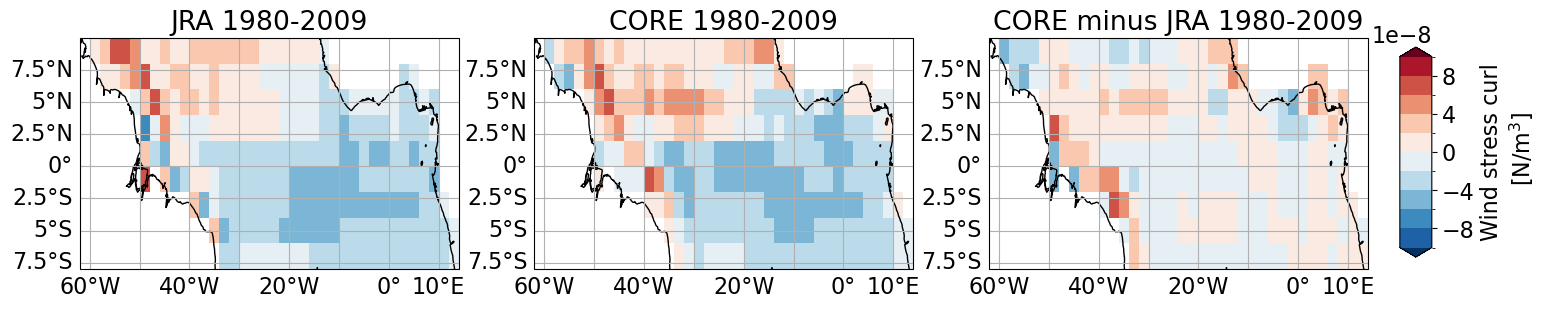

In [67]:
# Quick plot to show the results
tlim1_C,tlim2_C = '1980','2009'
tlim1_J,tlim2_J = '1980','2009'
lw=2
linest='dashed'
tau_curl_AM = tau_curl.sel(time_counter=slice('1980','2009')).mean('time_counter')

data_crs = ccrs.PlateCarree()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3),subplot_kw={'projection': ccrs.PlateCarree()})

im = plot_results(tau_curl_AM,'JRA',data_crs,axes[0])
im = plot_results(tau_curl_AM,'CORE',data_crs,axes[1])
im = plot_results(tau_curl_AM,'DIFF',data_crs,axes[2])

axes[0].set_title('JRA 1980-2009')
axes[1].set_title('CORE 1980-2009')
axes[2].set_title('CORE minus JRA 1980-2009')


fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cb =fig.colorbar(im, cax=cbar_ax, extend='both')
cb.set_label('Wind stress curl\n [N/m$^3$]')

plt.savefig(out_dir_fig+'2deg_INALT20_wind_forcing_maps_mean_1980_2009.png',dpi=300, bbox_inches='tight')

In [68]:
def calc_sv(tau_curl,e2u):
    rho=1025;
    Omega,R_earth = 7.271e-5,6.37e6
    beta=(2*Omega*np.cos(tau_curl.lat*(np.pi/180)))/R_earth
    T_sv_A=-(tau_curl/(rho*beta))*e2u
    return (T_sv_A.isel(lon=slice(None, None, -1)
            ).cumsum('lon')).isel(lon=slice(None, None, -1)
            ).where(tau_curl.notnull())*1e-6

In [69]:
TSV_mm = calc_sv(tau_curl,dy_taux)

2023-12-11 17:28:53,964 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-12-11 17:28:56,093 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-12-11 17:28:56,834 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-12-11 17:28:58,426 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


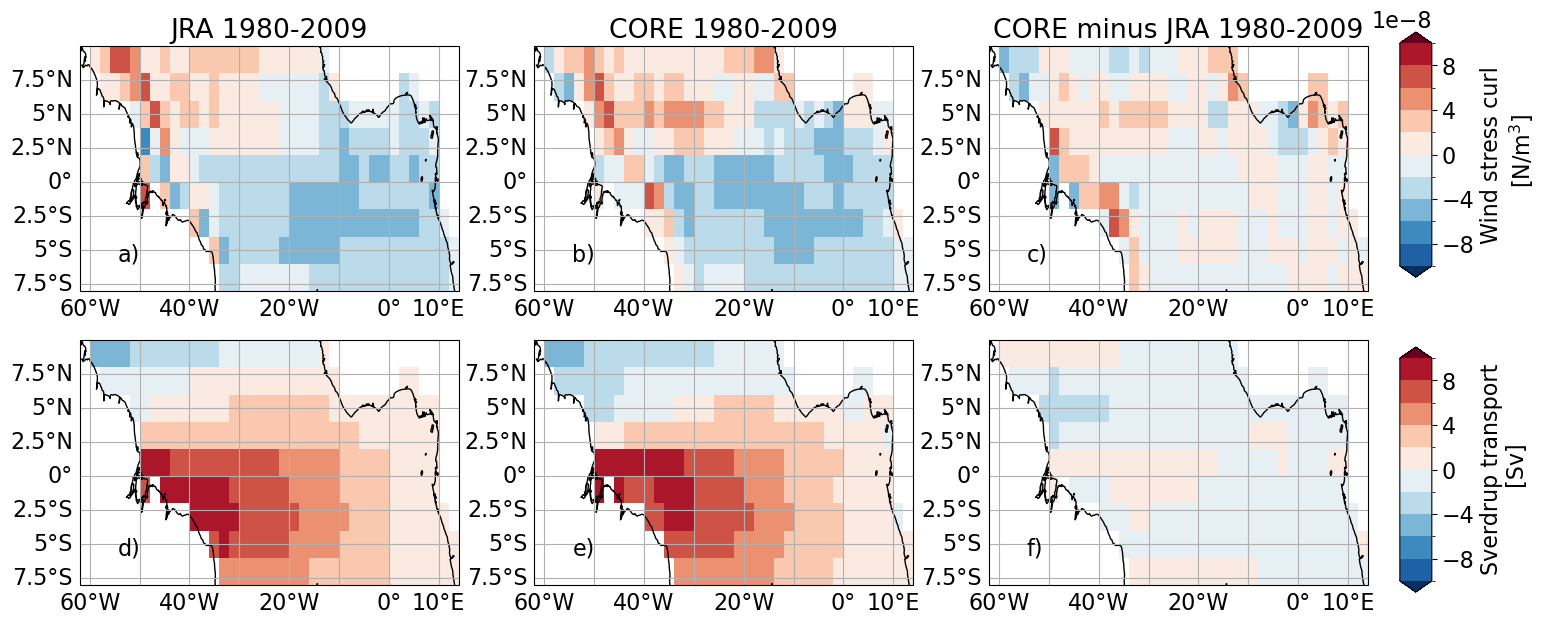

In [70]:
# Quick plot to show the results
tlim1_C,tlim2_C = '1980','2009'
tlim1_J,tlim2_J = '1980','2009'
lw=2
linest='dashed'

tau_curl_AM = tau_curl.sel(time_counter=slice('1980','2009')).mean('time_counter')
sv_AM = TSV_mm.sel(time_counter=slice('1980','2009')).mean('time_counter')

data_crs = ccrs.PlateCarree()

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16,7),subplot_kw={'projection': ccrs.PlateCarree()})

im = plot_results(tau_curl_AM,'JRA',data_crs,axes[0,0])
im = plot_results(tau_curl_AM,'CORE',data_crs,axes[0,1])
im = plot_results(tau_curl_AM,'DIFF',data_crs,axes[0,2])

axes[0,0].set_title('JRA 1980-2009')
axes[0,1].set_title('CORE 1980-2009')
axes[0,2].set_title('CORE minus JRA 1980-2009')


fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.55, 0.02, 0.35]) #[left, bottom, width, height] 
cb =fig.colorbar(im, cax=cbar_ax, extend='both')
cb.set_label('Wind stress curl\n [N/m$^3$]')

im = plot_sv(sv_AM,'JRA',data_crs,axes[1,0])
im = plot_sv(sv_AM,'CORE',data_crs,axes[1,1])
im = plot_sv(sv_AM,'DIFF',data_crs,axes[1,2])

cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.35])
cb =fig.colorbar(im, cax=cbar_ax, extend='both')
cb.set_label('Sverdrup transport\n [Sv]')

text_labels = ['a','b','c','d','e','f']

for i, ax in enumerate(axes.flat):
    ax.text(.1, .1, f'{text_labels[i]})', transform=ax.transAxes, ha="left", va="bottom")

plt.savefig(out_dir_fig+'2deg_INALT20_curl_and_sverdrup_maps_mean_1980_2009.png',dpi=300, bbox_inches='tight')

In [71]:
tau_curl_clim = tau_curl.sel(time_counter=slice('1980','2009')).groupby('time_counter.month').mean('time_counter')
tsv_mm_clim = TSV_mm.sel(time_counter=slice('1980','2009')).groupby('time_counter.month').mean('time_counter')

In [72]:
tsv_mmA = TSV_mm.groupby('time_counter.month')-tsv_mm_clim

/gxfs_work/geomar/smomw294/.conda/envs/py3_std/lib/python3.9/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 61 times more chunks
  return self.array[key]


In [73]:
def plot_10year_mean(TSV_mm,tlim):
    lw=2
    linest='dashed'
    tau_curl_AM = TSV_mm.sel(time_counter=slice(*tlim)).mean('time_counter')

    data_crs = ccrs.PlateCarree()

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3),subplot_kw={'projection': ccrs.PlateCarree()})

    im = plot_sv_10yrs(tau_curl_AM,'JRA',data_crs,axes[0])
    im = plot_sv_10yrs(tau_curl_AM,'CORE',data_crs,axes[1])
    im = plot_sv_10yrs(tau_curl_AM,'DIFF',data_crs,axes[2])

    axes[0].set_title(f'JRA {tlim[0]} - {tlim[1]}')
    axes[1].set_title(f'CORE {tlim[0]} - {tlim[1]}')
    axes[2].set_title(f'CORE minus JRA {tlim[0]} - {tlim[1]}')


    fig.subplots_adjust(right=0.93)
    cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
    cb =fig.colorbar(im, cax=cbar_ax, extend='both')
    cb.set_label('Sverdrup transport\n [Sv]')
    plt.tight_layout()

    plt.savefig(out_dir_fig+f'2deg_INALT20_sverdrup_maps_mean_{tlim[0]}_{tlim[1]}.png',dpi=300, bbox_inches='tight')

/tmp/ipykernel_3118548/3178161102.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
2023-12-11 17:29:14,121 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
/tmp/ipykernel_3118548/3178161102.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
2023-12-11 17:29:29,556 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
/tmp/ipykernel_3118548/3178161102.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_3118548/3178161102.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
2023-12-11 17:29:48,381 - distributed.ut

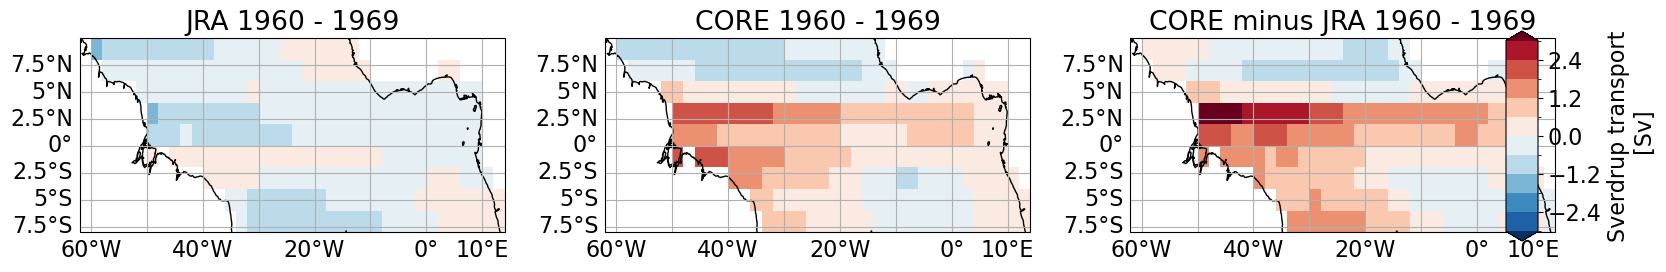

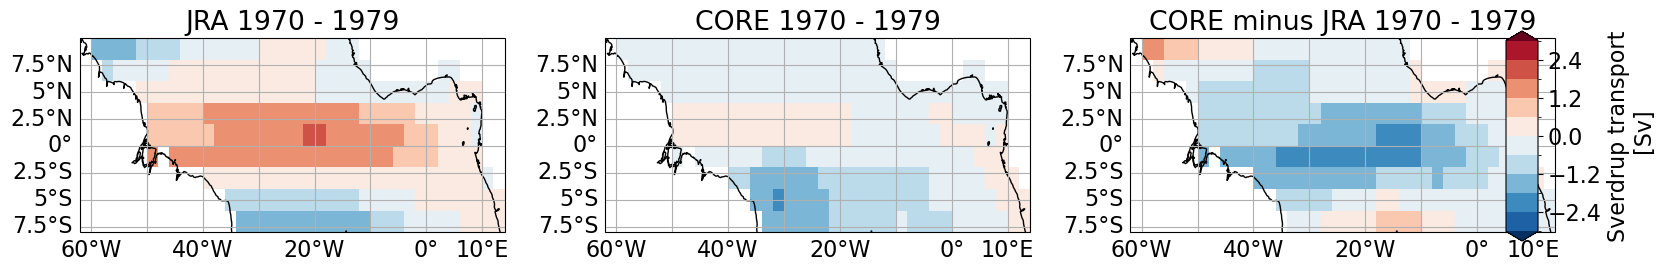

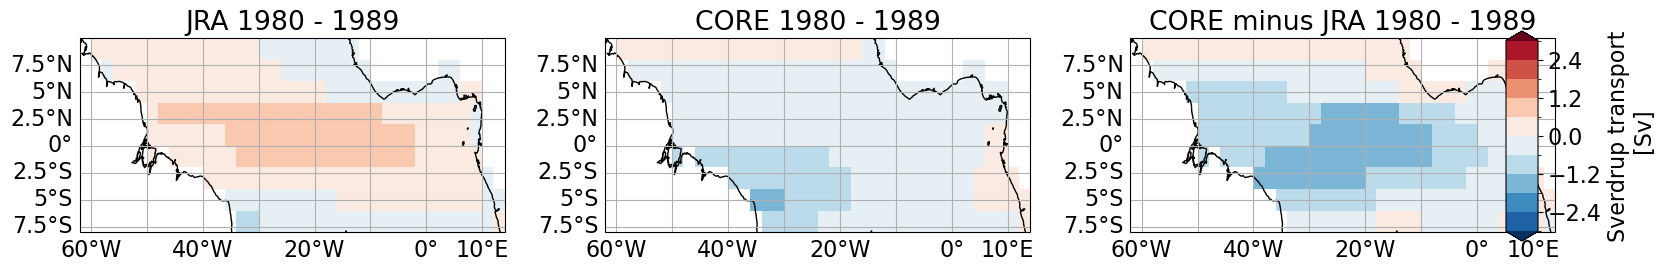

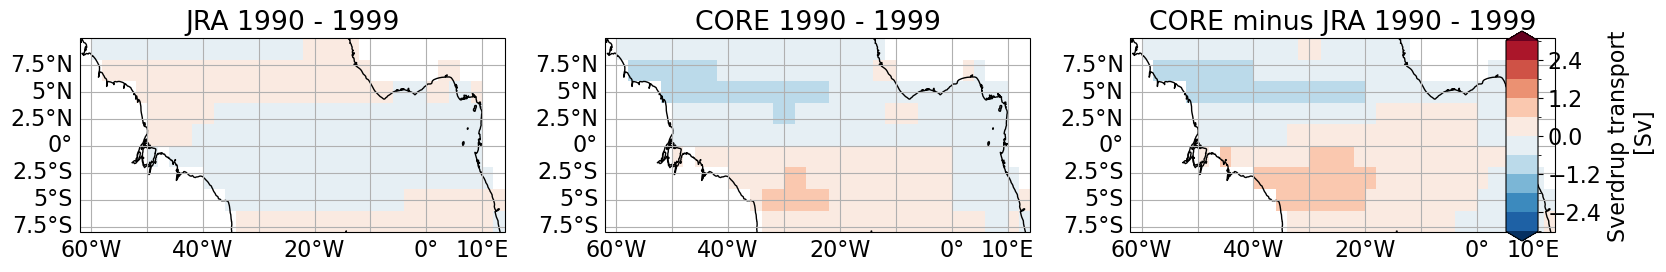

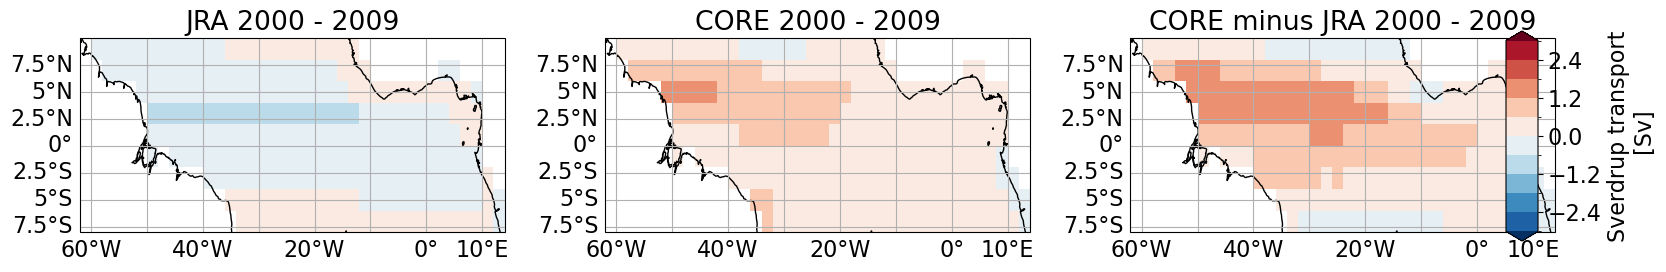

In [74]:
plot_10year_mean(tsv_mmA,['1960','1969'])
plot_10year_mean(tsv_mmA,['1970','1979'])
plot_10year_mean(tsv_mmA,['1980','1989'])
plot_10year_mean(tsv_mmA,['1990','1999'])
plot_10year_mean(tsv_mmA,['2000','2009'])

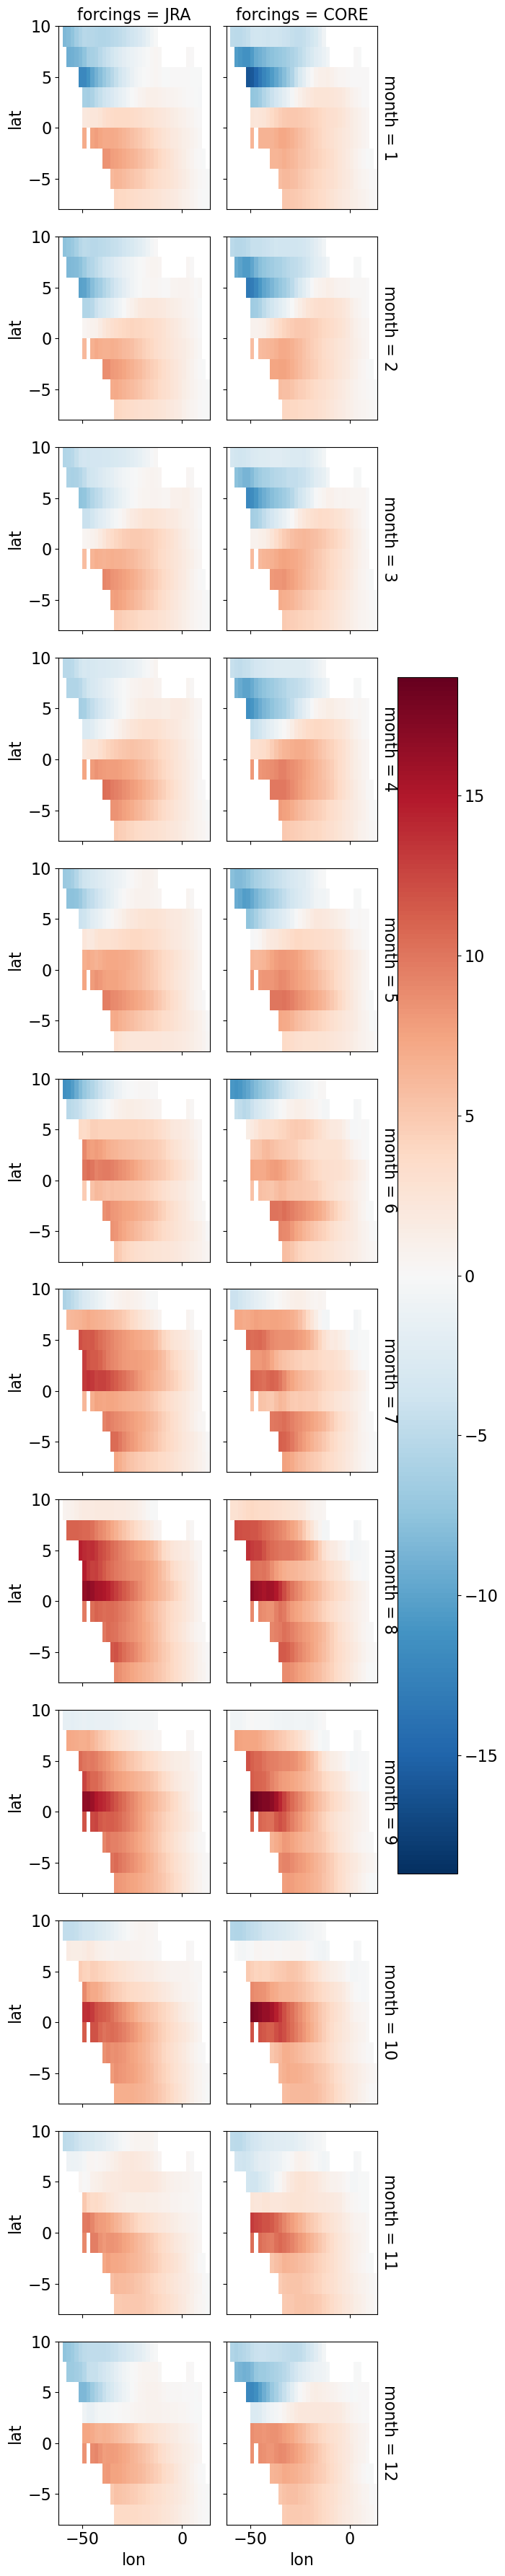

In [75]:
tsv_mm_clim.plot(col='forcings',row='month')

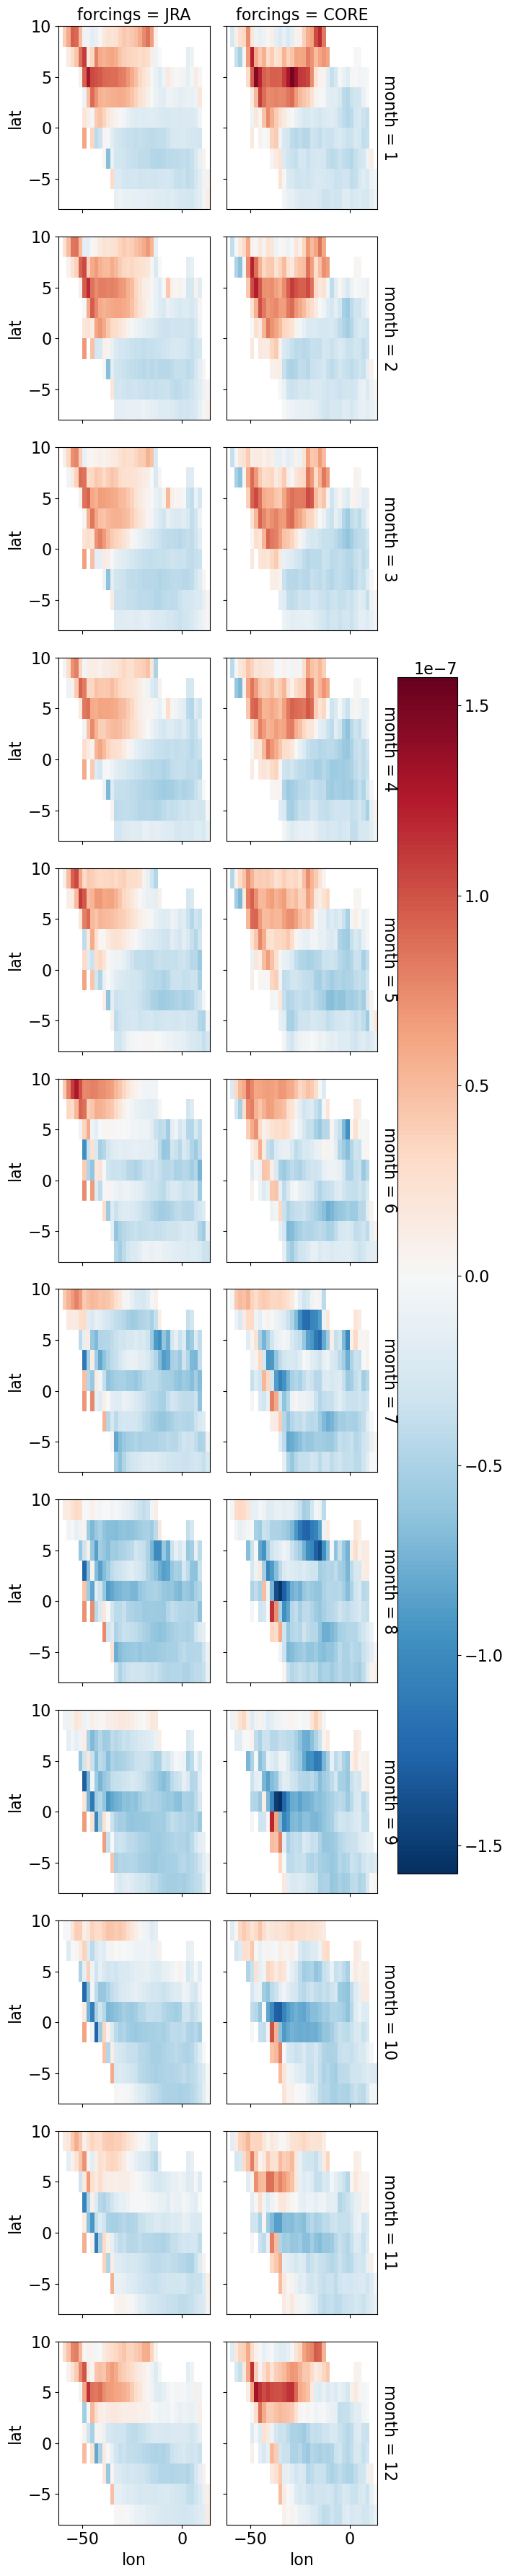

In [76]:
tau_curl_clim.plot(col='forcings',row='month')